# Surface type distinction to get melt factor depending on snow age 

a **surface type distinction model is included with a bucket system together with a melt_f that varies with age** inside of `TIModel_Sfc_Type`:
- there are two options included at the moment:
    - `melt_f_update=annual`
        - If annual, then it uses 1 snow
            and 5 firn buckets with yearly melt factor updates.
    - `melt_f_update=monthly`:
        -  If monthly, each month the snow is ageing over 6 years (i.e., 72 months -> 72 buckets).
    - the ice bucket is thought as an "infinite" bucket (because we do not know the ice thickness at this model stage)
    - Melt factors are interpolated linearly inbetween the buckets.
      TODO: include non-linear melt factor change as an option!
- default is to use a **spinup** of 5 years. So to compute the specific mass balance between 2000 and 2020, with `spinup=True`, the annual mb is computed since 1994 where at first everything is ice, and then it accumulates over the next years, so that in 2000 there is something in each bucket ...

- the ratio of snow melt factor to ice melt factor is set to 0.5 (as in GloGEM, PyGEM, ...) but it can be changed via `melt_f_ratio_snow_to_ice`
    - if we set `melt_f_ratio_snow_to_ice=1` the melt factor is equal for all buckets, hence the results are equal to no surface type distinction (as in `TIModel`)
- `get_annual_mb` and `get_monthly_mb` work as in PastMassBalance, however they only accept the height array that corresponds to the inversion height (so no mass-balance elevation feedback can be included at the moment!)
    - that means the given mass-balance ist the mass-balance over the inversion heights (before doing the inversion and so on)
- the buckets are automatically updated when using `get_annual_mb` or `get_monthly_mb` via the `TIModel_Sfc_Type.pd_bucket` dataframe 
- to make sure that we do not compute mass-balance twice and to always have a spin-up of 6 years, we save the mass balance under 
    - `get_annual_mb.pd_mb_annual`: for each year
        - when using `get_monthly_mb` for several years, after computing the December month, the `pd_mb_annual` dataframe is updated
    - `get_annual_mb.pd_mb_monthly`: for each month
        - note that this stays empty if we only use get_annual_mb with annual melt_f_update

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import pickle
import ast
import salem

import matplotlib.pyplot as plt
import matplotlib

from numpy.testing import assert_allclose
# %matplotlib inline
import statsmodels as stats
import scipy
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import os

import oggm
from oggm import cfg, utils, workflow, tasks, graphics, entity_task
from oggm.utils import date_to_floatyear
from oggm.shop import gcm_climate
from oggm.core import massbalance, flowline, climate

import logging
log = logging.getLogger(__name__)

cfg.initialize() #logging_level='WARNING'
cfg.PARAMS['use_multiprocessing'] = False

cfg.PARAMS['continue_on_error'] = False

cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-sfc-type', reset=True)

# use Huss flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

# import the MSsandbox modules

from MBsandbox.mbmod_daily_oneflowline import (process_era5_daily_data, process_w5e5_data, TIModel,
                                               BASENAMES, MultipleFlowlineMassBalance_TIModel, TIModel_Sfc_Type)

from MBsandbox.help_func import minimize_bias_geodetic, optimize_std_quot_brentq_geod

# from projections_bayescalibration import run_from_climate_data_TIModel, process_isimip_data,  MultipleFlowlineMassBalance_TIModel

cfg.PARAMS['hydro_month_nh']=1
df = ['RGI60-11.00897']
gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                              prepro_border=10,
                                              prepro_base_url=base_url,
                                              prepro_rgi_version='62')
gdir = gdirs[0]

2021-07-18 14:44:48: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-07-18 14:44:48: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-07-18 14:44:48: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-07-18 14:44:48: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2021-07-18 14:44:48: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2021-07-18 14:44:48: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2021-07-18 14:44:48: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands/RGI62/b_010/L2/RGI60-11/RGI60-11.00.tar verified successfully.


In [4]:
# get the geodetic data for calibration
url = 'https://cluster.klima.uni-bremen.de/~oggm/geodetic_ref_mb/hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide.csv'
path = utils.file_downloader(url)
pd_geodetic = pd.read_csv(path, index_col='rgiid')
pd_geodetic = pd_geodetic.loc[pd_geodetic.period == '2000-01-01_2020-01-01']
mb_geodetic = pd_geodetic.loc[df].dmdtda.values * 1000
years = np.arange(2000, 2020, 1)


2021-07-18 14:44:49: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/geodetic_ref_mb/hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide.csv verified successfully.


In [5]:
# this is the resolution of the precipitation and temperature 
temporal_resol = 'monthly'
baseline_climate = 'W5E5' #'ERA5_daily' 
# or 'ERA5dr', or 'ERA5'
mb_type = 'mb_monthly'
melt_f = 200
pf = 2

In [6]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# which climate do you use, @Patrick?
#if baseline_climate == 'ERA5dr':
#    cfg.PARAMS['baseline_climate'] = baseline_climate #'ERA5dr'
#    oggm.shop.ecmwf.process_ecmwf_data(gdir, output_filesuffix='_monthly_ERA5dr')
#elif baseline_climate == 'ERA5' and temporal_resol ==:
#    cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
#    process_era5_daily_data(gdir, output_filesuffix='_{}_ERA5')#

#else:                                                   
process_w5e5_data(gdir, temporal_resol=temporal_resol,
                          climate_type=baseline_climate,
                          )
h, w = gdir.get_inversion_flowline_hw()


2021-07-18 14:44:54: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_w5e5_data
2021-07-18 14:44:54: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_tas_global_daily_flat_glaciers_1979_2019.nc
2021-07-18 14:44:54: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_pr_global_daily_flat_glaciers_1979_2019.nc
2021-07-18 14:44:54: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_glacier_invariant_flat.nc
2021-07-18 14:45:09: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_lapserates_monthly.nc verified successfully.


In [7]:
fls = gdir.read_pickle('inversion_flowlines')

mb_mod_annual_1_a = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=1, prcp_fac=pf,
                                          melt_f_update='annual',
                                          baseline_climate=baseline_climate)
melt_f_opt_1_a = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                             xtol=0.01, args=(mb_mod_annual_1_a,
                                                              mb_geodetic,
                                                              h, w, pf, False,
                                                              years,
                                                              False, True  # do spinup before
                                                              ), disp=True)
mb_mod_annual_1_a.melt_f = melt_f_opt_1_a

spec_1_a = mb_mod_annual_1_a.get_specific_mb(year=years, fls=fls, spinup=True)


# get an instance of a TIModel_Sfc_Type with annual update of the melt factor (this is sufficient for the app)
mb_mod_annual_0_5_a = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,
                                  melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                    melt_f_update='annual',
                                  baseline_climate=baseline_climate
                                    )
melt_f_opt_0_5_a = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                      xtol=0.01, args=(mb_mod_annual_0_5_a,
                                                       mb_geodetic,
                                                       h, w, pf, False,
                                                       years,
                                                       False, True  # do spinup before
                                                       ), disp=True)
mb_mod_annual_0_5_a.melt_f = melt_f_opt_0_5_a
spec_0_5_a = mb_mod_annual_0_5_a.get_specific_mb(year=years, fls=fls, spinup=True)



# just for comparison: instance with no surface type distinction 
mb_mod_no_sfc_type = TIModel(gdir, melt_f, mb_type=mb_type,
                                     prcp_fac=pf, baseline_climate=baseline_climate)

melt_f_opt_no_sfc_type = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                      xtol=0.01, args=(mb_mod_no_sfc_type,
                                                       mb_geodetic,
                                                       h, w, pf, False,
                                                       years,
                                                       False, True  # do spinup before
                                                       ), disp=True)
mb_mod_no_sfc_type.melt_f = melt_f_opt_no_sfc_type


spec_no_sfc_type = mb_mod_no_sfc_type.get_specific_mb(year=years, fls=fls)



In [8]:
# with normal spinup for 5 years
mb_mod_monthly_0_5_m = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='monthly',
                                          baseline_climate=baseline_climate)
melt_f_opt_0_5_m = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_monthly_0_5_m,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)
mb_mod_monthly_0_5_m.melt_f = melt_f_opt_0_5_m
spec_0_5_m = mb_mod_monthly_0_5_m.get_specific_mb(year=years, fls=fls, spinup=True)
print(melt_f_opt_0_5_m)

390.2045799130138


In [10]:
mb_mod_monthly_0_5_m.pd_mb_monthly


1994.000000   1994.083333   1994.166667  \
distance_along_flowline                                             
0.0                      5.807445e-08  1.340948e-08  2.098761e-08   
100.0                    5.807445e-08  1.340948e-08  2.098761e-08   
200.0                    5.807445e-08  1.340948e-08  2.098761e-08   
300.0                    5.807445e-08  1.340948e-08  2.098761e-08   
400.0                    5.807445e-08  1.340948e-08  2.098761e-08   
500.0                    5.807445e-08  1.340948e-08  2.098761e-08   
600.0                    5.807445e-08  1.340948e-08  2.098761e-08   
700.0                    5.807445e-08  1.340948e-08  2.098761e-08   
800.0                    5.807445e-08  1.340948e-08  2.098761e-08   
900.0                    5.807445e-08  1.340948e-08  2.098761e-08   
1000.0                   5.807445e-08  1.340948e-08  2.098761e-08   
1100.0                   5.807445e-08  1.340948e-08  2.098761e-08   
1200.0                   5.807445e-08  1.340948e-08  2.098761e-08   
1300.0                   5.807445e-08  1.340948e-08  2.098761e-08   
1400.0                   5.807445e-08  1.340948e-08  2.098761e-08   
1500.0                   5.807445e-08  1.340948e-08  2.098761e-08   
1600.0                   5.807445e-08  1.340948e-08  2.098761e-08   
1700.0                   5.807445e-08  1.340948e-08  2.098761e-08   
1800.0                   5.807445e-08  1.340948e-08  2.098761e-08   
1900.0                   5.807445e-08  1.340948e-08  2.098761e-08   
2000.0                   5.807445e-08  1.340948e-08  2.098761e-08   
2100.0                   5.807445e-08  1.340948e-08  2.098761e-08   
2200.0                   5.807445e-08  1.340948e-08  2.098761e-08   
2300.0                   5.807445e-08  1.340948e-08  2.098761e-08   
2400.0                   5.807445e-08  1.340948e-08  2.098761e-08   
2500.0                   5.807445e-08  1.340948e-08  2.098761e-08   
2600.0                   5.807445e-08  1.340948e-08  2.098761e-08   
2700.0                   5.807445e-08  1.340948e-08  2.098761e-08   
2800.0                   5.807445e-08  1.340948e-08  2.098761e-08   
2900.0                   5.807445e-08  1.340948e-08  2.098761e-08   
3000.0                   5.807445e-08  1.340948e-08  2.098761e-08   
3100.0                   5.807445e-08  1.340948e-08  2.098761e-08   
3200.0                   5.807445e-08  1.340948e-08  2.098761e-08   
3300.0                   5.807445e-08  1.340948e-08  2.098761e-08   
3400.0                   5.807445e-08  1.340948e-08  2.098761e-08   
3500.0                   5.807445e-08  1.340948e-08  2.098761e-08   
3600.0                   5.807445e-08  1.340948e-08  2.098761e-08   
3700.0                   5.807445e-08  1.340948e-08  2.098761e-08   
3800.0                   5.807445e-08  1.340948e-08  2.098761e-08   
3900.0                   5.807445e-08  1.340948e-08  2.098761e-08   
4000.0                   5.807445e-08  1.340948e-08  2.098761e-08   
4100.0                   5.807445e-08  1.340948e-08  2.098761e-08   
4200.0                   5.807445e-08  1.340948e-08  2.098761e-08   
4300.0                   5.807445e-08  1.340948e-08  2.098761e-08   
4400.0                   5.807445e-08  1.340948e-08  2.098761e-08   
4500.0                   5.807445e-08  1.340948e-08  2.098761e-08   
4600.0                   5.807445e-08  1.340948e-08  2.098761e-08   
4700.0                   5.807445e-08  1.340948e-08  2.098761e-08   
4800.0                   5.807445e-08  1.340948e-08  2.098761e-08   
4900.0                   5.807445e-08  1.340948e-08  2.098761e-08   
5000.0                   5.807445e-08  1.340948e-08  2.098761e-08   
5100.0                   5.807445e-08  1.340948e-08  2.098761e-08   
5200.0                   5.807445e-08  1.340948e-08  2.098761e-08   
5300.0                   5.807445e-08  1.340948e-08  2.098761e-08   
5400.0                   5.807445e-08  1.340948e-08  2.098761e-08   
5500.0                   5.807445e-08  1.340948e-08  2.098761e-08   

                       

In [7]:
mb_grad_dict = {}
mb_annual_dict = {}
for mb, name in zip([mb_mod_monthly_0_5_m, mb_mod_annual_0_5_a, mb_mod_annual_1_a],
                    ['0_5_m', '0_5_a', '1_a']):
    mb_grad_dict_name = []
    mb_annual_dict_name = {}
    for y in years:
        mb_y = mb.pd_mb_annual[y]
        mb_gradient,_,_,_,_ = scipy.stats.linregress(h[mb_y<0], y=mb_y[mb_y<0]) 
        mb_grad_dict_name.append(mb_gradient)
        mb_annual_dict_name[y] = mb_y
    mb_grad_dict[name] = np.array(mb_grad_dict_name)
    mb_annual_dict[name] = mb_annual_dict_name


In [8]:
mb_grad_dict_m = {}
mb_monthly_dict = {}
bucket = {}
k=1
for mb, name in zip([mb_mod_monthly_0_5_m, mb_mod_annual_0_5_a, mb_mod_annual_1_a],
                    ['0_5_m', '0_5_a', '1_a']):
    # need to reset otherwise I can't get the pd_buckets right!!!
    mb.reset_pd_mb_bucket()
    mb_grad_dict_name = []
    mb_monthly_dict_name = {}
    bucket_name = {}
    for y in years:
        for m in np.arange(1,13,1):
            floatyr = date_to_floatyear(y,m)
            #if name != '0_5_m':
            _, bucket_name[floatyr] = mb.get_monthly_mb(h, year=floatyr, bucket_output =True)
            mb_m = mb.pd_mb_monthly[floatyr]
            try:
                mb_gradient,_,_,_,_ = scipy.stats.linregress(h[mb_m<0], y=mb_m[mb_m<0]) 
            except:
                mb_gradient = np.NaN
            mb_grad_dict_name.append(mb_gradient)
            mb_monthly_dict_name[floatyr] = mb_m
    mb_grad_dict_m[name] = np.array(mb_grad_dict_name)
    mb_monthly_dict[name] = mb_monthly_dict_name
    bucket[name] = bucket_name



In [9]:
bucket['0_5_m'][2000.0].iloc[:10]

0          1           2           3  \
distance_along_flowline                                                 
0.0                      47.690647  98.990334  100.531563  126.843994   
100.0                    47.690647  98.990334  100.531563  126.843994   
200.0                    47.690647  98.990334  100.531563  126.843994   
300.0                    47.690647  98.990334  100.531563  126.843994   
400.0                    47.690647  98.990334  100.531563  126.843994   
500.0                    47.690647  98.990334  100.531563  126.843994   
600.0                    47.690647  98.990334  100.531563  126.843994   
700.0                    47.690647  98.990334  100.531563  126.843994   
800.0                    47.690647  98.990334  100.531563  126.843994   
900.0                    47.690647  98.990334  100.531563  126.843994   

                                  4           5           6           7  \
distance_along_flowline                                                   
0.0                      233.308472  242.039246  172.346756  226.782455   
100.0                    233.308472  242.039246  172.346756  226.782455   
200.0                    233.308472  242.039246  172.346756  226.782455   
300.0                    233.308472  242.039246  172.346756  226.782455   
400.0                    233.308472  242.039246  172.346756  226.782455   
500.0                    233.308472  242.039246  101.207018  226.782455   
600.0                    233.308472  186.170838   38.248894  226.782455   
700.0                    233.308472  116.954050    0.000000  203.120216   
800.0                    233.308472   39.688309    0.000000  133.416666   
900.0                    233.308472    0.000000    0.000000   28.333520   

                                  8          9  ...   63   64   65   66   67  \
distance_along_flowline                         ...                            
0.0                      199.952728  103.76207  ...  0.0  0.0  0.0  0.0  0.0   
100.0                    199.952728  103.76207  ...  0.0  0.0  0.0  0.0  0.0   
200.0                    199.952728  103.76207  ...  0.0  0.0  0.0  0.0  0.0   
300.0                    199.952728  103.76207  ...  0.0  0.0  0.0  0.0  0.0   
400.0                    199.952728  103.76207  ...  0.0  0.0  0.0  0.0  0.0   
500.0                    199.952728  103.76207  ...  0.0  0.0  0.0  0.0  0.0   
600.0                    199.952728  103.76207  ...  0.0  0.0  0.0  0.0  0.0   
700.0                    199.952728  103.76207  ...  0.0  0.0  0.0  0.0  0.0   
800.0                    199.952728  103.76207  ...  0.0  0.0  0.0  0.0  0.0   
900.0                    199.952728  103.76207  ...  0.0  0.0  0.0  0.0  0.0   

                          68   69   70   71  delta_kg/m2  
distance_along_flowline                                   
0.0                      0.0  0.0  0.0  0.0    47.690647  
100.0                    0.0  0.0  0.0  0.0    47.690647  
200.0                    0.0  0.0  0.0  0.0    47.690647  
300.0                    0.0  0.0  0.0  0.0    47.690647  
400.0                    0.0  0.0  0.0  0.0    47.690647  
500.0                    0.0  0.0  0.0  0.0    47.690647  
600.0                    0.0  0.0  0.0  0.0    47.690647  
700.0                    0.0  0.0  0.0  0.0    47.690647  
800.0                    0.0  0.0  0.0  0.0    47.690647  
900.0                    0.0  0.0  0.0  0.0    47.690647  

[10 rows x 73 columns]

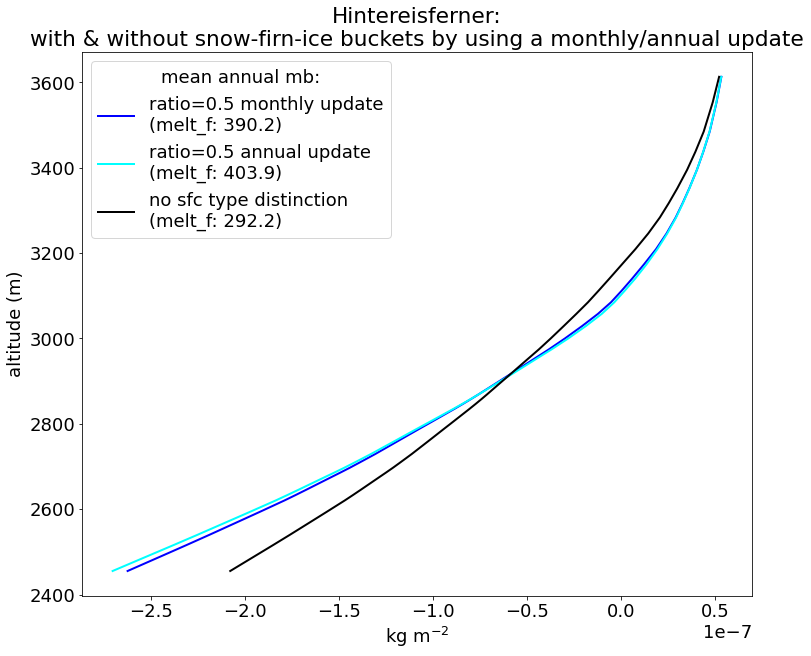

In [10]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12, 10))
lw=2


#plt.subplot(122)

plt.plot(pd.DataFrame(mb_annual_dict['0_5_m']).mean(axis=1).values,
         h, label='ratio=0.5 monthly update\n(melt_f: {:0.1f})'.format(melt_f_opt_0_5_m), color = 'blue', 
         lw=lw)
plt.plot(pd.DataFrame(mb_annual_dict['0_5_a']).mean(axis=1).values,
         h, label='ratio=0.5 annual update\n(melt_f: {:0.1f})'.format(melt_f_opt_0_5_a), color='cyan',
         lw=lw)
plt.plot(pd.DataFrame(mb_annual_dict['1_a']).mean(axis=1).values,
         h, label='no sfc type distinction\n(melt_f: {:0.1f})'.format(melt_f_opt_1_a), color='black',
         lw=lw)
plt.xlabel('kg m$^{-2}$')
plt.ylabel('altitude (m)')
plt.legend(title='mean annual mb:')
plt.title('Hintereisferner:\nwith & without snow-firn-ice buckets by using a monthly/annual update')
plt.savefig('mb_profile_hef.png')

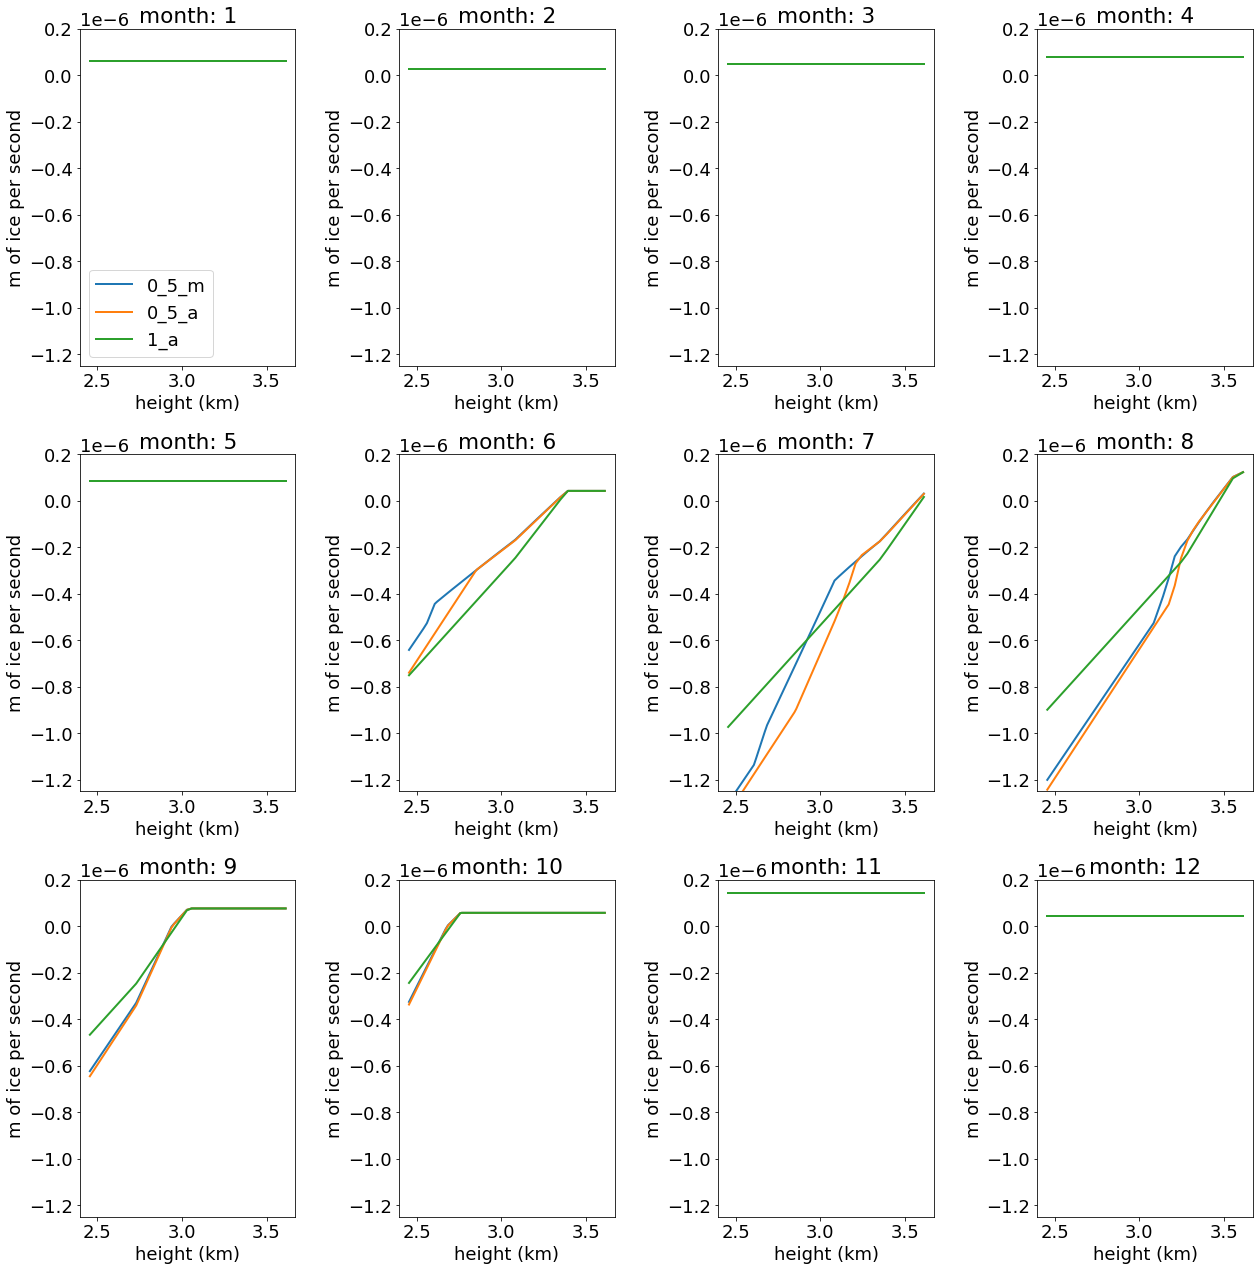

In [11]:
plt.figure(figsize=(18,18))
k =1

for m in np.arange(1,13, 1):
    floatyr = date_to_floatyear(y,m)

    plt.subplot(3,4,k)
    for mb, name in zip([mb_mod_monthly_0_5_m, mb_mod_annual_0_5_a, mb_mod_annual_1_a],
                        ['0_5_m', '0_5_a', '1_a']):

        plt.plot(h/1000, mb_monthly_dict[name][floatyr], label=name, lw=2)
        plt.title('month: {}'.format(m))
    plt.ylim(-1.25e-6, 0.2e-6)
    if k==1:
        plt.legend()
    k +=1
    plt.ylabel('m of ice per second')
    plt.xlabel('height (km)')
plt.tight_layout()
plt.savefig('monthly_mb_hef.png')

In [12]:
cmap = plt.get_cmap('viridis')
lw=3
ls = {'0_5_m':'--', '0_5_a': '-'}
    #colors[0]='black'
for year in np.arange(2000,2002,1): # 2020
    plt.figure(figsize=(18,18))
    k =1

    for m in np.arange(1,13,1):
        floatyr = date_to_floatyear(year,m)

        plt.subplot(3,4,k)
        for mb, name in zip([mb_mod_monthly_0_5_m, mb_mod_annual_0_5_a], #[1:],
                            ['0_5_m', '0_5_a']#[1:]
                           ):
            colors = [cmap(i) for i in np.linspace(0.2, 1, 6)][::-1]
            for j in np.arange(0, 6, 1):
                #enumerate(bucket[name][floatyr].columns[:-1]):
                if name == '0_5_m':
                    plt.plot(bucket[name][floatyr].index/1000,
                             #bucket[name][floatyr][b, b+12].sum(axis=1),
                             bucket[name][floatyr][np.arange(12*j, 12*j+12,1)].sum(axis=1),
                             color = colors[j], lw=lw, ls =ls[name])
                else:
                    b = bucket[name][floatyr].columns[j]
                    plt.plot(bucket[name][floatyr].index/1000,
                             bucket[name][floatyr][b],
                             label = b, color = colors[j],
                             lw=lw, ls = ls[name])
                    if k==1:
                        plt.legend()

        #if k==1:
        #    plt.legend()
        #plt.title('year: {}, ratio non-ice to all: {}'.format(yr, np.round(ratio,3)))
        k += 1
        plt.title(m)
        plt.ylabel('kg/m2')
        plt.xlabel('distance along flowline (km)')
        #plt.ylim([0, 10100])
    #plt.suptitle(name)
    plt.tight_layout()
    plt.savefig('pd_buckets_test_hef_{}_summed_over_yr.png'.format(year))
    plt.close()

In [13]:
cmap = plt.get_cmap('viridis')
lw=3
ls = {'0_5_m':'-', '0_5_a': '-'}
    #colors[0]='black'
pal = sns.color_palette("viridis")
for year in np.arange(2000,2002,1): # 2020
    for mb, name in zip([mb_mod_annual_0_5_a, mb_mod_monthly_0_5_m], #[1:],
                            ['0_5_a', '0_5_m']#[1:]
                           ):
        plt.figure(figsize=(18,18))
        k =1
        for m in np.arange(1,13,1):
            plt.subplot(3,4,k)

            floatyr = date_to_floatyear(year,m)

            bucket_names = bucket[name][floatyr].columns[:-1][::-1]

            colors = [cmap(i) for i in np.linspace(0, 0.95, len(bucket_names))]
            #for j,b in enumerate(bucket_names):
                    #enumerate(bucket[name][floatyr].columns[:-1]):
                    #if name == '0_5_m':
                    #plt.plot(bucket[name][floatyr].index/1000,
                    #             #bucket[name][floatyr][b, b+12].sum(axis=1),
                    #             bucket[name][floatyr][np.arange(12*j, 12*j+12,1)].sum(axis=1),
                    #             color = colors[j], lw=lw, ls =ls[name])
                    #plt.plot(bucket[name][floatyr].index/1000,
                    #             bucket[name][floatyr][b],
                    #             label = b, color = colors[j],
                    #             lw=lw, ls = ls[name])
            plt.stackplot(bucket[name][floatyr][bucket_names].index/1000,
                          bucket[name][floatyr][bucket_names].T.values,
                          labels = bucket_names, colors = colors)
            #plt.legend()
                    
            if k==1 and name == '0_5_a':
                plt.legend()

            #if k==1:
            #    plt.legend()
            #plt.title('year: {}, ratio non-ice to all: {}'.format(yr, np.round(ratio,3)))
            k += 1
            plt.title(m)
            plt.ylabel('kg/m2')
            plt.xlabel('distance along flowline (km)')
            plt.ylim([0, 10100])
        plt.suptitle('{}, year = {}'.format(name,year))
        plt.tight_layout()
        plt.savefig('pd_buckets_test_hef_{}_{}.png'.format(name, year))
        plt.close()

# Comparison of no spinup, 6 year spinup (default) and 20 year spinup!

In [39]:
# with no spinup
mb_mod_monthly_0_5_m_no_spinup = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='monthly',
                                          baseline_climate=baseline_climate)
melt_f_opt_0_5_m_no_spinup = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_monthly_0_5_m,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, False, # do spinup before
                                                      ), disp=True)
mb_mod_monthly_0_5_m_no_spinup.melt_f = melt_f_opt_0_5_m_no_spinup
spec_0_5_m_no_spinup = mb_mod_monthly_0_5_m_no_spinup.get_specific_mb(year=years, fls=fls, spinup=False) #!!!
print(melt_f_opt_0_5_m_no_spinup)

389.3091660934973


In [42]:
mb_mod_monthly_0_5_m_no_spinup.pd_mb_annual # this should only start in 2000!!!

2000          2001          2002  \
distance_along_flowline                                             
0.0                      7.162706e-08  5.759800e-08  6.698137e-08   
100.0                    7.162706e-08  5.605020e-08  6.698137e-08   
200.0                    7.066383e-08  5.126869e-08  6.698137e-08   
300.0                    6.728412e-08  4.791540e-08  6.698137e-08   
400.0                    6.429387e-08  4.493037e-08  6.631624e-08   
500.0                    6.117956e-08  4.184157e-08  6.367005e-08   
600.0                    5.869902e-08  3.750052e-08  6.080181e-08   
700.0                    5.627249e-08  3.275956e-08  5.654290e-08   
800.0                    5.227055e-08  2.794235e-08  4.928786e-08   
900.0                    4.740596e-08  2.359747e-08  4.210108e-08   
1000.0                   4.304840e-08  1.932280e-08  3.496324e-08   
1100.0                   3.945543e-08  1.533380e-08  2.817369e-08   
1200.0                   3.631446e-08  1.184763e-08  2.207649e-08   
1300.0                   3.333175e-08  8.468544e-09  1.638580e-08   
1400.0                   3.031706e-08  5.079913e-09  1.037434e-08   
1500.0                   2.621524e-08  1.741118e-09  3.910996e-09   
1600.0                   2.014356e-08 -1.206705e-09 -3.884520e-09   
1700.0                   1.462693e-08 -3.801477e-09 -1.324394e-08   
1800.0                   5.777454e-09 -5.900416e-09 -2.054768e-08   
1900.0                  -5.471581e-10 -7.477745e-09 -2.608382e-08   
2000.0                  -6.563703e-09 -8.978244e-09 -3.137293e-08   
2100.0                  -1.129059e-08 -1.028426e-08 -3.562721e-08   
2200.0                  -1.601757e-08 -1.209014e-08 -4.025057e-08   
2300.0                  -2.027411e-08 -1.496022e-08 -4.351311e-08   
2400.0                  -2.451728e-08 -1.754960e-08 -4.656888e-08   
2500.0                  -2.917475e-08 -1.983449e-08 -4.962464e-08   
2600.0                  -3.422286e-08 -2.230678e-08 -5.291796e-08   
2700.0                  -3.958245e-08 -2.493184e-08 -5.641099e-08   
2800.0                  -4.511147e-08 -2.800621e-08 -6.001459e-08   
2900.0                  -5.360953e-08 -3.664347e-08 -6.553166e-08   
3000.0                  -6.196014e-08 -4.455105e-08 -7.060708e-08   
3100.0                  -6.889189e-08 -5.026593e-08 -7.428341e-08   
3200.0                  -7.582364e-08 -5.598175e-08 -7.795974e-08   
3300.0                  -8.141083e-08 -6.087705e-08 -8.069269e-08   
3400.0                  -8.660834e-08 -6.562579e-08 -8.307918e-08   
3500.0                  -9.180584e-08 -7.037453e-08 -8.546568e-08   
3600.0                  -9.747474e-08 -7.555386e-08 -8.806857e-08   
3700.0                  -1.034602e-07 -8.102242e-08 -9.081675e-08   
3800.0                  -1.094456e-07 -8.649138e-08 -9.356492e-08   
3900.0                  -1.157714e-07 -9.227160e-08 -9.646940e-08   
4000.0                  -1.223612e-07 -9.829366e-08 -9.956313e-08   
4100.0                  -1.289662e-07 -1.043299e-07 -1.032717e-07   
4200.0                  -1.370001e-07 -1.117058e-07 -1.077824e-07   
4300.0                  -1.439539e-07 -1.191055e-07 -1.122932e-07   
4400.0                  -1.498860e-07 -1.259316e-07 -1.164540e-07   
4500.0                  -1.555937e-07 -1.324997e-07 -1.204574e-07   
4600.0                  -1.614565e-07 -1.392466e-07 -1.245696e-07   
4700.0                  -1.676066e-07 -1.463241e-07 -1.296691e-07   
4800.0                  -1.738545e-07 -1.533243e-07 -1.348501e-07   
4900.0                  -1.812303e-07 -1.615602e-07 -1.427237e-07   
5000.0                  -1.891639e-07 -1.704193e-07 -1.517328e-07   
5100.0                  -1.993776e-07 -1.817103e-07 -1.629498e-07   
5200.0                  -2.123338e-07 -1.945511e-07 -1.755732e-07   
5300.0                  -2.247209e-07 -2.061029e-07 -1.877479e-07   
5400.0                  -2.354859e-07 -2.164645e-07 -1.986681e-07   
5500.0                  -2.445544e-07 -2.252294e-07 -2.078514e-07   

                              

In [16]:
# with a spinup for 20 years
mb_mod_monthly_0_5_m_20yr_spinup = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='monthly',
                                          baseline_climate=baseline_climate)
mb_mod_monthly_0_5_m_20yr_spinup.spinup_yrs = 20
melt_f_opt_0_5_m_20yr_spinup = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_monthly_0_5_m,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)
mb_mod_monthly_0_5_m_20yr_spinup.melt_f = melt_f_opt_0_5_m_20yr_spinup
spec_0_5_m_20yr_spinup = mb_mod_monthly_0_5_m_20yr_spinup.get_specific_mb(year=years, fls=fls, spinup=True)
print(melt_f_opt_0_5_m_20yr_spinup)


390.2045799130138


In [41]:
mb_mod_monthly_0_5_m_20yr_spinup.pd_mb_annual.iloc[0] # this should have 20 yr spinup

1980    5.159279e-08
1981    7.159670e-08
1982    5.621100e-08
1983    5.305807e-08
1984    5.282843e-08
1985    5.613840e-08
1986    5.843636e-08
1987    6.297973e-08
1988    5.570402e-08
1989    5.018381e-08
1990    5.093465e-08
1991    4.892744e-08
1992    5.741771e-08
1993    6.428395e-08
1994    4.817071e-08
1995    4.912857e-08
1996    6.196301e-08
1997    4.230911e-08
1998    4.944209e-08
1999    6.476429e-08
2000    7.162706e-08
2001    5.759800e-08
2002    6.698137e-08
2003    3.033576e-08
2004    4.764873e-08
2005    4.835527e-08
2006    2.948887e-08
2007    5.327428e-08
2008    6.377943e-08
2009    5.026271e-08
2010    5.749402e-08
2011    5.249351e-08
2012    5.881053e-08
2013    5.494269e-08
2014    6.020742e-08
2015    2.828510e-08
2016    5.555469e-08
2017    5.891608e-08
2018    5.297220e-08
2019    6.798702e-08
Name: 0.0, dtype: float64

In [43]:
mb_grad_dict = {}
mb_annual_dict = {}
for mb, name in zip([mb_mod_monthly_0_5_m, mb_mod_monthly_0_5_m_no_spinup, mb_mod_monthly_0_5_m_20yr_spinup,
                     mb_mod_annual_0_5_a, mb_mod_annual_1_a],
                    ['0_5_m', '0_5_m_no_spinup', '0_5_m_20yr_spinup', '0_5_a', '1_a']):
    mb_grad_dict_name = []
    mb_annual_dict_name = {}
    for y in years:
        mb_y = mb.pd_mb_annual[y]
        mb_gradient,_,_,_,_ = scipy.stats.linregress(h[mb_y<0], y=mb_y[mb_y<0]) 
        mb_grad_dict_name.append(mb_gradient)
        mb_annual_dict_name[y] = mb_y
    mb_grad_dict[name] = np.array(mb_grad_dict_name)
    mb_annual_dict[name] = mb_annual_dict_name


In [44]:
melt_f_opt_0_5_m_20yr_spinup

390.2045799130138

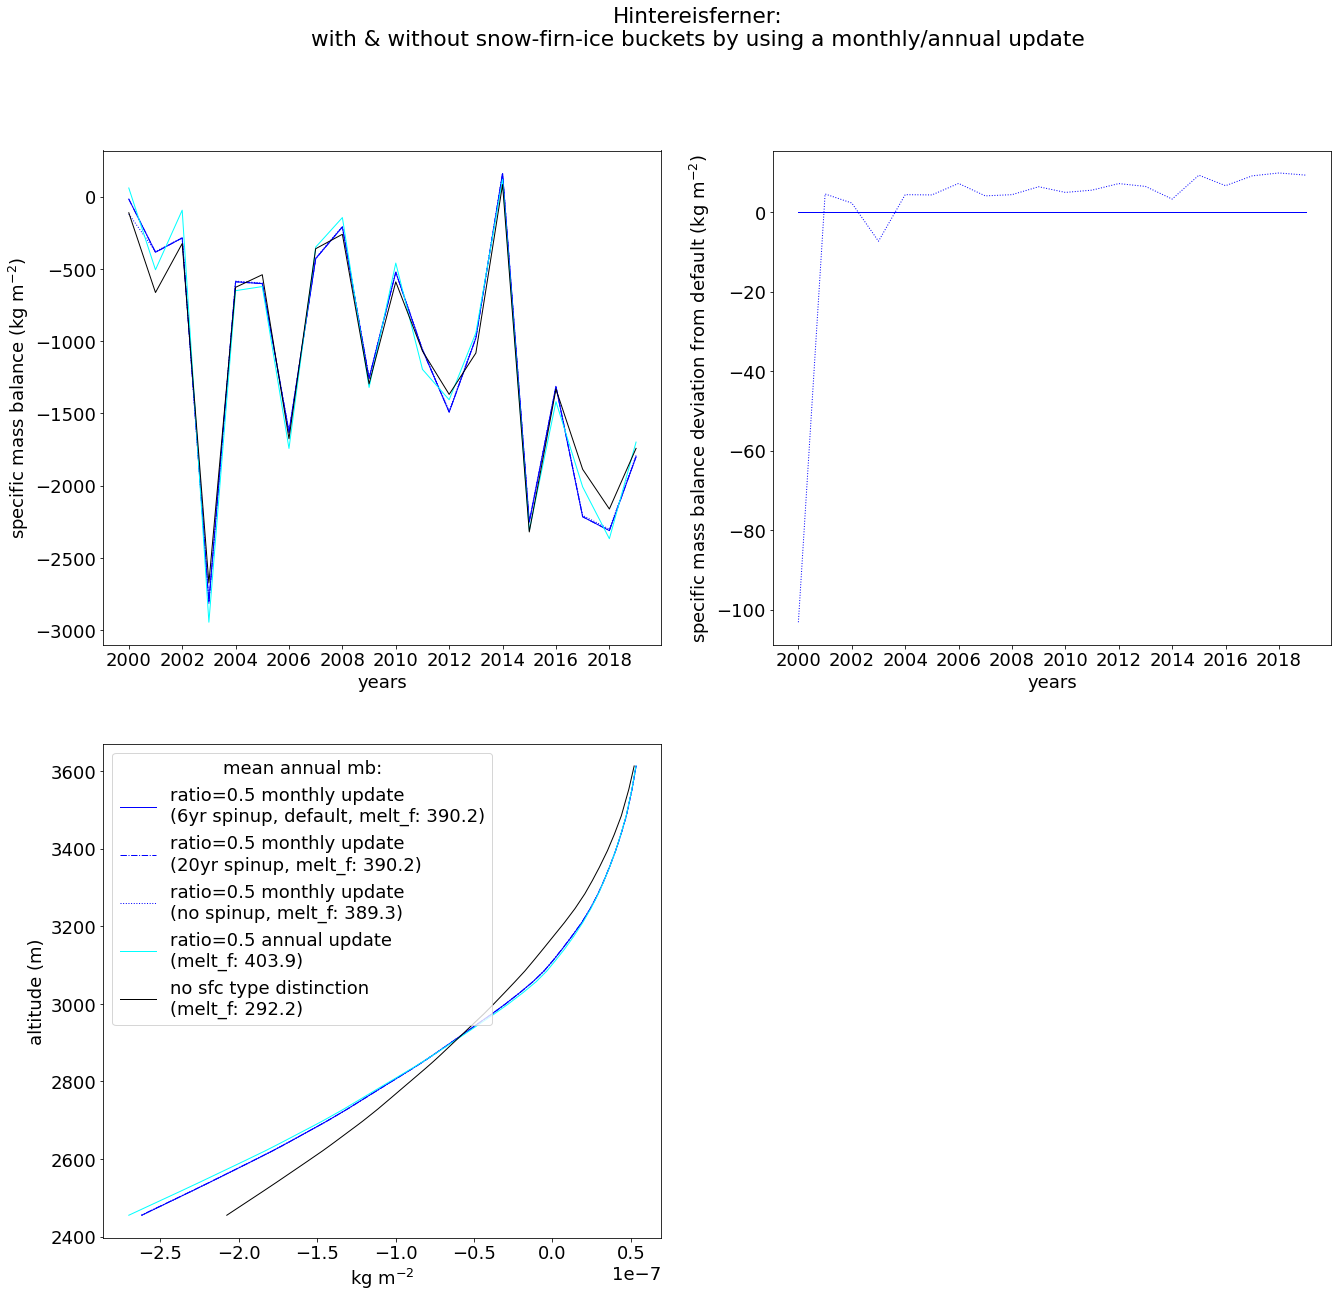

In [45]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(22, 20))
lw=1


plt.subplot(221)
plt.plot(years, spec_0_5_m, color = 'blue', lw=lw)
plt.plot(years, spec_0_5_m_20yr_spinup, color = 'blue', lw=lw, ls= '-.')
plt.plot(years, spec_0_5_m_no_spinup, color = 'blue', lw=lw, ls = ':')
plt.plot(years, spec_0_5_a, color = 'cyan', lw=lw)
plt.plot(years, spec_1_a, color = 'black', lw=lw)

plt.xticks(np.arange(2000, 2020,2))

#plt.legend(bbox_to_anchor=(1.2,1))
plt.xlabel('years')
plt.ylabel('specific mass balance (kg m$^{-2}$)')

plt.subplot(222)
plt.plot(years, spec_0_5_m-spec_0_5_m, color = 'blue', lw=lw)
plt.plot(years, spec_0_5_m_20yr_spinup-spec_0_5_m, color = 'blue', lw=lw, ls= '-.')
plt.plot(years, spec_0_5_m_no_spinup-spec_0_5_m, color = 'blue', lw=lw, ls = ':')
#plt.plot(years, spec_0_5_a, color = 'cyan', lw=lw)
#plt.plot(years, spec_1_a, color = 'black', lw=lw)

plt.xticks(np.arange(2000, 2020,2))

plt.xlabel('years')
plt.ylabel('specific mass balance deviation from default (kg m$^{-2}$)')

assert_allclose(spec_0_5_m, spec_0_5_m_20yr_spinup)


plt.subplot(223)

plt.plot(pd.DataFrame(mb_annual_dict['0_5_m']).mean(axis=1).values,
         h, label='ratio=0.5 monthly update\n(6yr spinup, default, melt_f: {:0.1f})'.format(melt_f_opt_0_5_m), color = 'blue', 
         lw=lw)
plt.plot(pd.DataFrame(mb_annual_dict['0_5_m_20yr_spinup']).mean(axis=1).values,
         h, label='ratio=0.5 monthly update\n(20yr spinup, melt_f: {:0.1f})'.format(melt_f_opt_0_5_m_20yr_spinup), color = 'blue', 
         lw=lw, ls='-.')
plt.plot(pd.DataFrame(mb_annual_dict['0_5_m_no_spinup']).mean(axis=1).values,
         h, label='ratio=0.5 monthly update\n(no spinup, melt_f: {:0.1f})'.format(melt_f_opt_0_5_m_no_spinup), color = 'blue', 
         lw=lw, ls = ':')
plt.plot(pd.DataFrame(mb_annual_dict['0_5_a']).mean(axis=1).values,
         h, label='ratio=0.5 annual update\n(melt_f: {:0.1f})'.format(melt_f_opt_0_5_a), color='cyan',
         lw=lw)
plt.plot(pd.DataFrame(mb_annual_dict['1_a']).mean(axis=1).values,
         h, label='no sfc type distinction\n(melt_f: {:0.1f})'.format(melt_f_opt_1_a), color='black',
         lw=lw)
plt.xlabel('kg m$^{-2}$')
plt.ylabel('altitude (m)')
plt.legend(title='mean annual mb:')
plt.suptitle('Hintereisferner:\nwith & without snow-firn-ice buckets by using a monthly/annual update')
plt.savefig('mb_profile_hef_spinup.png')



- if we don't use a spinup, the calibrated melt_f is slightly smaller, this results in slightly less negative mass balance over the calibration period except for the first year which is much more negative (because everything is expected to be snow!!!)
    - without a spinup, over the long period we have a problem because of a positive mass-balance bias then ... 

## Steps towards non-linear change of melt factor 
- do we have any literature of how melt factor changes for different albedo, is it a linear relation??? 
- Ice is less reflective than snow, ice melts more per positive degree day than snow: But how does this relation change over time for different "firn" stages???
 **need to find a relation of albedo vs snow age**-> if this is logarithmic we can say that DDF factor also decreases in a logarithmic way?!
 
			-  COSIPY, Sauter 2020: fresh snow albedo $\alpha_s$=0.9; firn albedo $\alpha_f$=0.55; ice albedo $\alpha_i$=0.3
				-   αsnow = αf + (αs − αf) exp (-s/t_albedo)
				-  The albedo timescale τ_albedo specifies how fast the snow albedo drops from fresh snow to firn. The number of days after the last snowfall is given by parameter s. Besides the temporal change, the overall snowpack thickness impacts the albedo. If the thickness of the snowpack d is thin, the albedo must tend towards the albedo of ice αi. If one introduces a charac- teristic snow depth scale d_star (e-folding), the full albedo can be written as:
					-  α = αsnow + (αi − αsnow) exp (-d/d_star)
				-  The model resets the albedo to fresh snow, if the snow accumulation exceeds a certain threshold (default value is 0.01 m) within one time step. This approach neglects sudden short-term jumps in albedo, which can occur when thin fresh snow layers quickly melt away. To account for this effect, the age of the underlying snow is also tracked. If the fresh snow layer melts faster than τ_albedo, the age of the snow cover is reset to the value of the underlying snow (Gurgiser et al., 2013)

In [109]:
# with normal spinup for 6 years
mb_mod_monthly_0_5_m_neg_exp = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='monthly',
                                          melt_f_change = 'neg_exp', 
                                          tau_e_fold_yr = 0.5, # default
                                          baseline_climate=baseline_climate)

melt_f_opt_0_5_m_neg_exp = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_monthly_0_5_m_neg_exp,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)

mb_mod_monthly_0_5_m_neg_exp.melt_f = melt_f_opt_0_5_m_neg_exp
spec_0_5_m_neg_exp = mb_mod_monthly_0_5_m_neg_exp.get_specific_mb(year=years, fls=fls, spinup=True)
print(melt_f_opt_0_5_m_neg_exp)

# with normal spinup for 6 years
mb_mod_monthly_0_5_m_neg_exp_tau1yr = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='monthly',
                                          melt_f_change = 'neg_exp', 
                                          tau_e_fold_yr = 1, # default
                                          baseline_climate=baseline_climate)

melt_f_opt_0_5_m_neg_exp_tau1yr = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_monthly_0_5_m_neg_exp_tau1yr,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)

mb_mod_monthly_0_5_m_neg_exp_tau1yr.melt_f = melt_f_opt_0_5_m_neg_exp_tau1yr
spec_0_5_m_neg_exp_tau1yr = mb_mod_monthly_0_5_m_neg_exp_tau1yr.get_specific_mb(year=years, fls=fls, spinup=True)
print(melt_f_opt_0_5_m_neg_exp_tau1yr)

337.4920179362608
355.98723342179477


In [110]:
# with normal spinup for 5 years
mb_mod_annual_0_5_a_neg_exp = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='annual',
                                          melt_f_change = 'neg_exp', 
                                          tau_e_fold_yr = 0.5, # default
                                          baseline_climate=baseline_climate)

melt_f_opt_0_5_a_neg_exp = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_annual_0_5_a_neg_exp,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)
mb_mod_annual_0_5_a_neg_exp.melt_f = melt_f_opt_0_5_a_neg_exp
spec_0_5_a_neg_exp = mb_mod_annual_0_5_a_neg_exp.get_specific_mb(year=years, fls=fls, spinup=True)
print(melt_f_opt_0_5_a_neg_exp)


# with normal spinup for 5 years
mb_mod_annual_0_5_a_neg_exp_tau1yr = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='annual',
                                          melt_f_change = 'neg_exp', 
                                          tau_e_fold_yr = 1, # default
                                          baseline_climate=baseline_climate)

melt_f_opt_0_5_a_neg_exp_tau1yr = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_annual_0_5_a_neg_exp_tau1yr,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)
mb_mod_annual_0_5_a_neg_exp_tau1yr.melt_f = melt_f_opt_0_5_a_neg_exp_tau1yr
spec_0_5_a_neg_exp_tau1yr = mb_mod_annual_0_5_a_neg_exp_tau1yr.get_specific_mb(year=years, fls=fls, spinup=True)
print(melt_f_opt_0_5_a_neg_exp_tau1yr)

assert_allclose(spec_0_5_a_neg_exp.mean(), spec_0_5_a_neg_exp_tau1yr.mean(),rtol=1e-5)

399.27344532711646
400.62189634019524


In [123]:
mb_grad_dict = {}
mb_annual_dict = {}
for mb, name in zip([mb_mod_monthly_0_5_m_neg_exp_tau1yr, mb_mod_monthly_0_5_m_neg_exp, mb_mod_monthly_0_5_m, mb_mod_annual_0_5_a_neg_exp,
                     mb_mod_annual_0_5_a_neg_exp_tau1yr, mb_mod_annual_0_5_a, mb_mod_annual_1_a],
                    ['0_5_m_neg_exp_tau1yr', '0_5_m_neg_exp', '0_5_m', '0_5_a_neg_exp_tau1yr', '0_5_a_neg_exp','0_5_a', '1_a']):
    mb_grad_dict_name = []
    mb_annual_dict_name = {}
    for y in years:
        mb_y = mb.pd_mb_annual[y]
        mb_gradient,_,_,_,_ = scipy.stats.linregress(h[mb_y<0], y=mb_y[mb_y<0]) 
        mb_grad_dict_name.append(mb_gradient)
        mb_annual_dict_name[y] = mb_y
    mb_grad_dict[name] = np.array(mb_grad_dict_name)
    mb_annual_dict[name] = mb_annual_dict_name


In [125]:
mb_grad_dict_m = {}
mb_monthly_dict = {}
bucket = {}
k=1
for mb, name in zip([mb_mod_monthly_0_5_m_neg_exp_tau1yr, mb_mod_monthly_0_5_m_neg_exp, mb_mod_monthly_0_5_m, mb_mod_annual_0_5_a_neg_exp,
                     mb_mod_annual_0_5_a_neg_exp_tau1yr, mb_mod_annual_0_5_a, mb_mod_annual_1_a],
                    ['0_5_m_neg_exp_tau1yr', '0_5_m_neg_exp', '0_5_m', '0_5_a_neg_exp_tau1yr', '0_5_a_neg_exp','0_5_a', '1_a']):
    # need to reset otherwise I can't get the pd_buckets right!!!
    mb.reset_pd_mb_bucket()
    mb_grad_dict_name = []
    mb_monthly_dict_name = {}
    bucket_name = {}
    for y in years:
        for m in np.arange(1,13,1):
            floatyr = date_to_floatyear(y,m)
            #if name != '0_5_m':
            _, bucket_name[floatyr] = mb.get_monthly_mb(h, year=floatyr, bucket_output =True)
            mb_m = mb.pd_mb_monthly[floatyr]
            try:
                mb_gradient,_,_,_,_ = scipy.stats.linregress(h[mb_m<0], y=mb_m[mb_m<0]) 
            except:
                mb_gradient = np.NaN
            mb_grad_dict_name.append(mb_gradient)
            mb_monthly_dict_name[floatyr] = mb_m
    mb_grad_dict_m[name] = np.array(mb_grad_dict_name)
    mb_monthly_dict[name] = mb_monthly_dict_name
    bucket[name] = bucket_name



- no visible differences anymore between annual and montly update for the mass balance profile 
    - what about the specific mass balance???

In [44]:
#gdir.get_ref_mb_data(input_filesuffix='_'+baseline_climate+'_monthly')

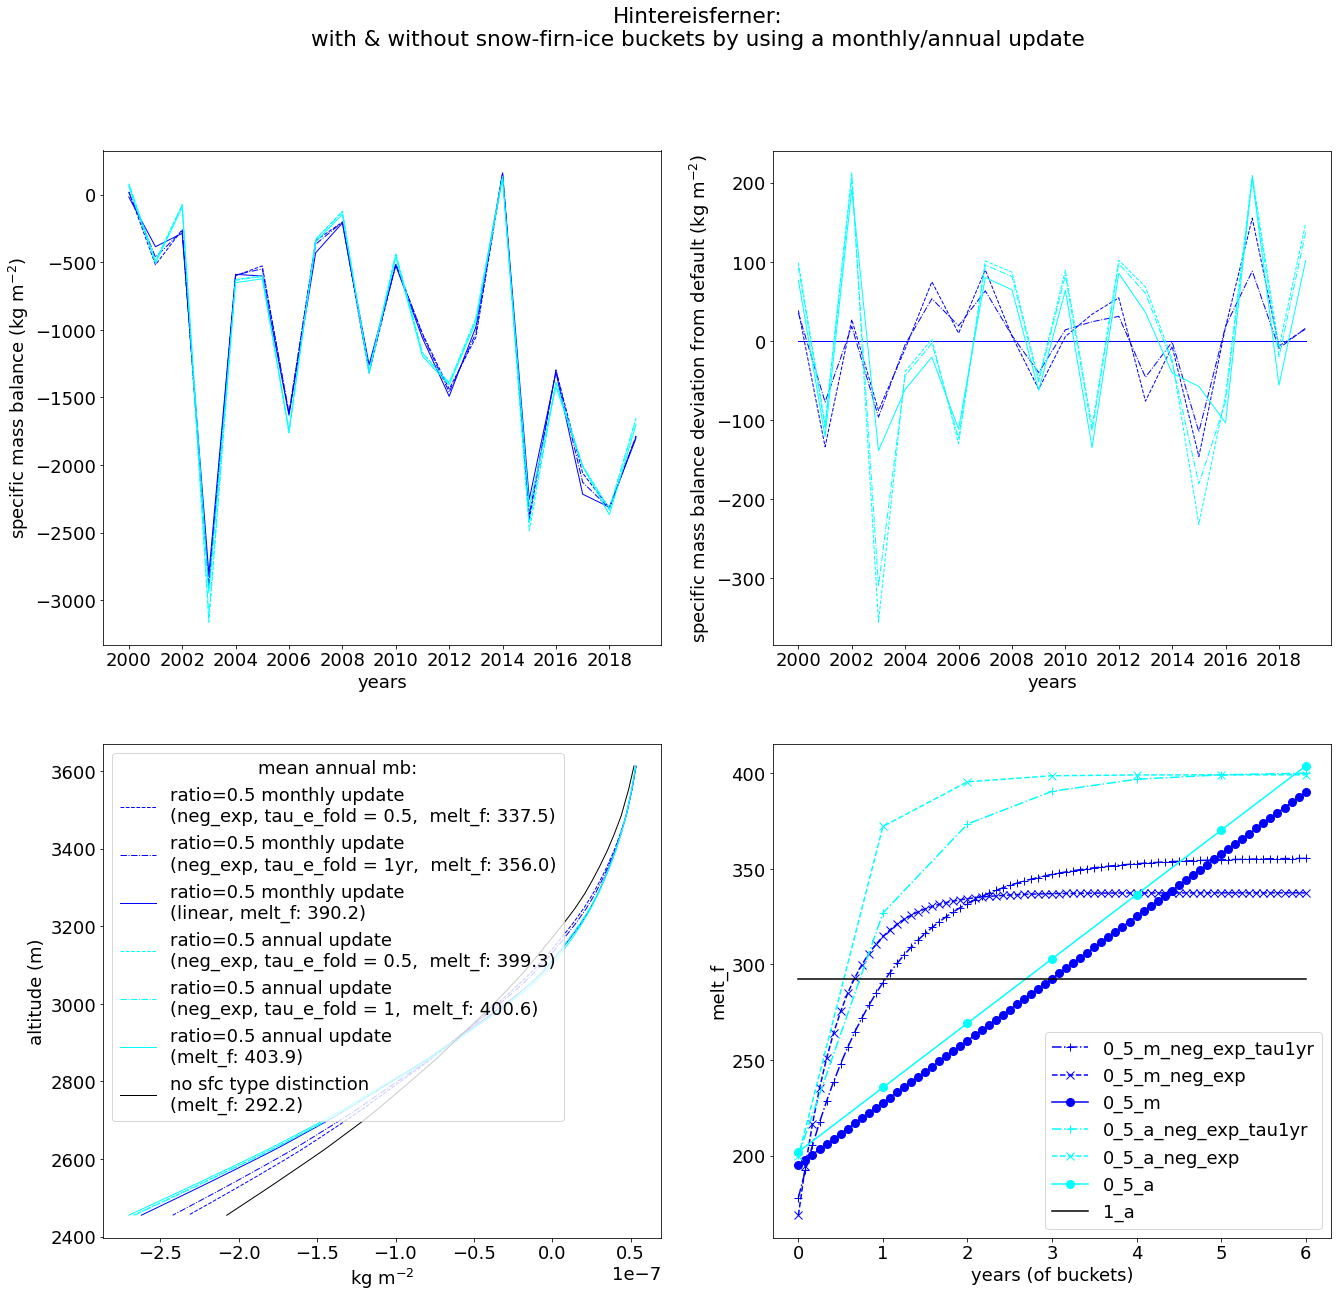

In [143]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(22, 20))
lw=1

plt.suptitle('Hintereisferner:\nwith & without snow-firn-ice buckets by using a monthly/annual update')

plt.subplot(221)
plt.plot(years, spec_0_5_m, color = 'blue', lw=lw)
plt.plot(years, spec_0_5_m_neg_exp, color = 'blue', lw=lw, ls= '--')
plt.plot(years, spec_0_5_m_neg_exp_tau1yr, color = 'blue', lw=lw, ls= '-.')

plt.plot(years, spec_0_5_a, color = 'cyan', lw=lw)
plt.plot(years, spec_0_5_a_neg_exp, color = 'cyan', lw=lw, ls ='--')
plt.plot(years, spec_0_5_a_neg_exp_tau1yr, color = 'cyan', lw=lw, ls ='-.')

plt.xticks(np.arange(2000, 2020,2))

#plt.legend(bbox_to_anchor=(1.2,1))
plt.xlabel('years')
plt.ylabel('specific mass balance (kg m$^{-2}$)')

plt.subplot(222)
plt.plot(years, spec_0_5_m-spec_0_5_m, color = 'blue', lw=lw)
plt.plot(years, spec_0_5_m_neg_exp-spec_0_5_m, color = 'blue', lw=lw, ls= '--')
plt.plot(years, spec_0_5_m_neg_exp_tau1yr-spec_0_5_m, color = 'blue', lw=lw, ls= '-.')
plt.plot(years, spec_0_5_a-spec_0_5_m, color = 'cyan', lw=lw, ls = '-')
plt.plot(years, spec_0_5_a_neg_exp-spec_0_5_m, color = 'cyan', lw=lw, ls = '--')
plt.plot(years, spec_0_5_a_neg_exp_tau1yr-spec_0_5_m, color = 'cyan', lw=lw, ls = '-.')

#plt.plot(years, spec_0_5_a, color = 'cyan', lw=lw)
#plt.plot(years, spec_1_a, color = 'black', lw=lw)

plt.xticks(np.arange(2000, 2020,2))

plt.xlabel('years')
plt.ylabel('specific mass balance deviation from default (kg m$^{-2}$)')

#assert_allclose(spec_0_5_m, spec_0_5_m_20yr_spinup)
lw=1
plt.subplot(223)
#plt.figure(figsize=(20,10))
plt.plot(pd.DataFrame(mb_annual_dict['0_5_m_neg_exp']).mean(axis=1).values,
         h, label='ratio=0.5 monthly update\n(neg_exp, tau_e_fold = 0.5,  melt_f: {:0.1f})'.format(melt_f_opt_0_5_m_neg_exp), color = 'blue', 
         lw=lw, ls ='--')
plt.plot(pd.DataFrame(mb_annual_dict['0_5_m_neg_exp_tau1yr']).mean(axis=1).values,
         h, label='ratio=0.5 monthly update\n(neg_exp, tau_e_fold = 1yr,  melt_f: {:0.1f})'.format(melt_f_opt_0_5_m_neg_exp_tau1yr), color = 'blue', 
         lw=lw, ls ='-.')
plt.plot(pd.DataFrame(mb_annual_dict['0_5_m']).mean(axis=1).values,
         h, label='ratio=0.5 monthly update\n(linear, melt_f: {:0.1f})'.format(melt_f_opt_0_5_m), color = 'blue', 
         lw=lw, ls = '-')
plt.plot(pd.DataFrame(mb_annual_dict['0_5_a_neg_exp']).mean(axis=1).values,
         h, label='ratio=0.5 annual update\n(neg_exp, tau_e_fold = 0.5,  melt_f: {:0.1f})'.format(melt_f_opt_0_5_a_neg_exp), color = 'cyan', 
         lw=lw, ls ='--')
plt.plot(pd.DataFrame(mb_annual_dict['0_5_a_neg_exp_tau1yr']).mean(axis=1).values,
         h, label='ratio=0.5 annual update\n(neg_exp, tau_e_fold = 1,  melt_f: {:0.1f})'.format(melt_f_opt_0_5_a_neg_exp_tau1yr), color = 'cyan', 
         lw=lw, ls ='-.')
plt.plot(pd.DataFrame(mb_annual_dict['0_5_a']).mean(axis=1).values,
         h, label='ratio=0.5 annual update\n(melt_f: {:0.1f})'.format(melt_f_opt_0_5_a), color='cyan',
         lw=lw)
plt.plot(pd.DataFrame(mb_annual_dict['1_a']).mean(axis=1).values,
         h, label='no sfc type distinction\n(melt_f: {:0.1f})'.format(melt_f_opt_1_a), color='black',
         lw=lw)
plt.xlabel('kg m$^{-2}$')
plt.ylabel('altitude (m)')
plt.legend(title='mean annual mb:')

plt.subplot(224)


for mb, name in zip([mb_mod_monthly_0_5_m_neg_exp_tau1yr, mb_mod_monthly_0_5_m_neg_exp, mb_mod_monthly_0_5_m,
                     mb_mod_annual_0_5_a_neg_exp_tau1yr, mb_mod_annual_0_5_a_neg_exp, mb_mod_annual_0_5_a, mb_mod_annual_1_a],
                    ['0_5_m_neg_exp_tau1yr', '0_5_m_neg_exp', '0_5_m', '0_5_a_neg_exp_tau1yr', '0_5_a_neg_exp','0_5_a', '1_a']):
    if 'm' in name:
        time = np.linspace(0, 6, 6*12+1)
        color = 'blue'
    elif 'a' in name:
        time = np.linspace(0, 6, 7)
        color = 'cyan'
    if '1_a' in name:
        color = 'k'
        ms = '-'
    elif 'neg_exp_tau1yr' in name:
        ls = '-.'
        ms = '+'
    elif 'neg_exp' in name:
        ls = '--'
        ms = 'x'
    else:
        ls = '-'
        ms= 'o'
    plt.plot(time, mb.melt_f_buckets.values(), ms, markersize=8,
             ls = ls, 
             label = name, color = color)
plt.legend()
plt.xlabel('years (of buckets)')
plt.ylabel('melt_f')
plt.savefig('mb_hef_melt_f_linear_vs_neg_exp.png')


In [46]:
y

2019

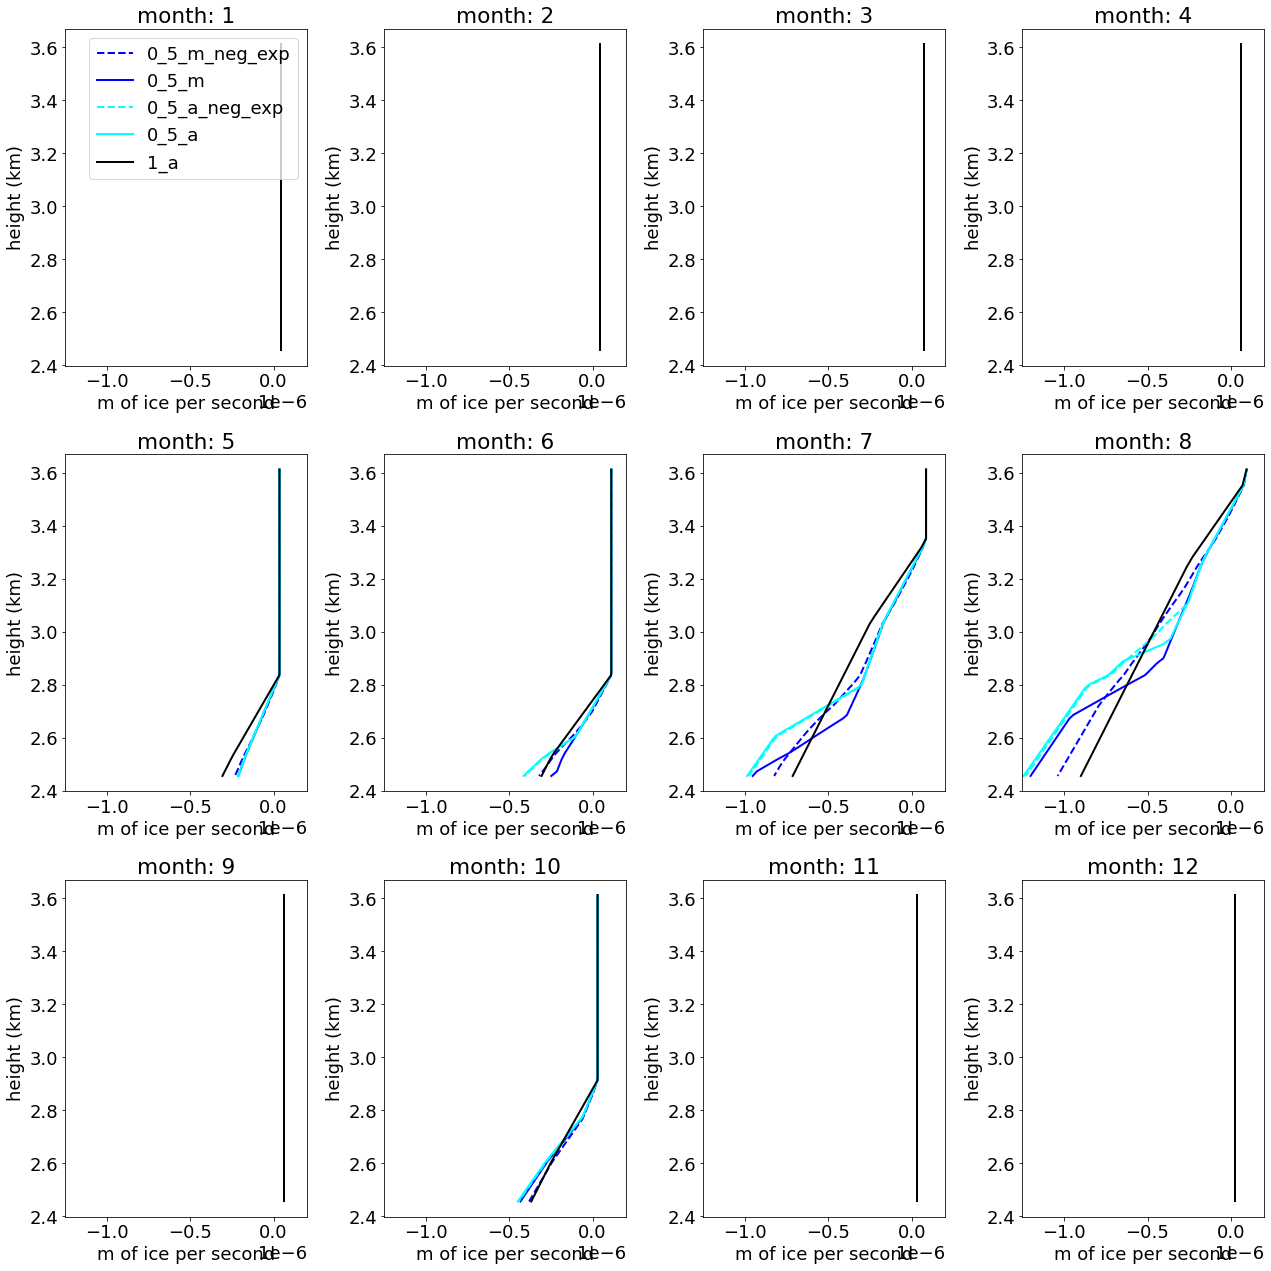

In [48]:
plt.figure(figsize=(18,18))
k =1
y = 2001
for m in np.arange(1,13, 1):
    floatyr = date_to_floatyear(y,m)

    plt.subplot(3,4,k)
    for mb, name in zip([mb_mod_monthly_0_5_m_neg_exp, mb_mod_monthly_0_5_m, mb_mod_annual_0_5_a_neg_exp,
                     mb_mod_annual_0_5_a, mb_mod_annual_1_a],
                    ['0_5_m_neg_exp', '0_5_m', '0_5_a_neg_exp','0_5_a', '1_a']):
        
        if 'm' in name:
            time = np.linspace(0, 6, 6*12+1)
            color = 'blue'
        elif 'a' in name:
            time = np.linspace(0, 6, 7)
            color = 'cyan'
        if '1' in name:
            color = 'k'
        if 'neg_exp' in name:
            ls = '--'
        else:
            ls = '-'

        plt.plot(mb_monthly_dict[name][floatyr], h/1000, 
                 label=name, lw=2, ls = ls, color=color)
        plt.title('month: {}'.format(m))
    plt.xlim(-1.25e-6, 0.2e-6)
    if k==1:
        plt.legend()
    k +=1
    plt.xlabel('m of ice per second')
    plt.ylabel('height (km)')
plt.tight_layout()
plt.savefig('monthly_mb_hef_melt_f_linear_vs_neg_exp_yr{}.png'.format(y))

- actually how the buckets are filled is quite similar between 'linear' and 'neg_exp' melt_f_change approach (but not exactly the same ...), would rather need tho show a "difference" plot

In [49]:
cmap = plt.get_cmap('viridis')
lw=3
#colors[0]='black'
pal = sns.color_palette("viridis")
for year in np.arange(2000,2002,1): # 2020
    for mb, name in zip([mb_mod_monthly_0_5_m_neg_exp, mb_mod_monthly_0_5_m, mb_mod_annual_0_5_a_neg_exp,
                     mb_mod_annual_0_5_a, mb_mod_annual_1_a],
                    ['0_5_m_neg_exp', '0_5_m', '0_5_a_neg_exp','0_5_a', '1_a']):
        plt.figure(figsize=(18,18))
        k =1
        for m in np.arange(1,13,1):
            plt.subplot(3,4,k)

            floatyr = date_to_floatyear(year,m)

            bucket_names = bucket[name][floatyr].columns[:-1][::-1]

            colors = [cmap(i) for i in np.linspace(0, 0.95, len(bucket_names))]
            #for j,b in enumerate(bucket_names):
                    #enumerate(bucket[name][floatyr].columns[:-1]):
                    #if name == '0_5_m':
                    #plt.plot(bucket[name][floatyr].index/1000,
                    #             #bucket[name][floatyr][b, b+12].sum(axis=1),
                    #             bucket[name][floatyr][np.arange(12*j, 12*j+12,1)].sum(axis=1),
                    #             color = colors[j], lw=lw, ls =ls[name])
                    #plt.plot(bucket[name][floatyr].index/1000,
                    #             bucket[name][floatyr][b],
                    #             label = b, color = colors[j],
                    #             lw=lw, ls = ls[name])
            plt.stackplot(bucket[name][floatyr][bucket_names].index/1000,
                          bucket[name][floatyr][bucket_names].T.values,
                          labels = bucket_names, colors = colors)
            #plt.legend()
                    
            if k==1 and name == '0_5_a':
                plt.legend()

            #if k==1:
            #    plt.legend()
            #plt.title('year: {}, ratio non-ice to all: {}'.format(yr, np.round(ratio,3)))
            k += 1
            plt.title(m)
            plt.ylabel('kg/m2')
            plt.xlabel('distance along flowline (km)')
            plt.ylim([0, 10100])
        plt.suptitle('{}, year = {}'.format(name,year))
        plt.tight_layout()
        plt.savefig('pd_buckets_test_hef_{}_{}.png'.format(name, year))
        plt.close()

In [62]:
mb_mod_monthly_0_5_a_neg_exp_tau_1yr.buckets

['snow', 'firn_yr_1', 'firn_yr_2', 'firn_yr_3', 'firn_yr_4', 'firn_yr_5']

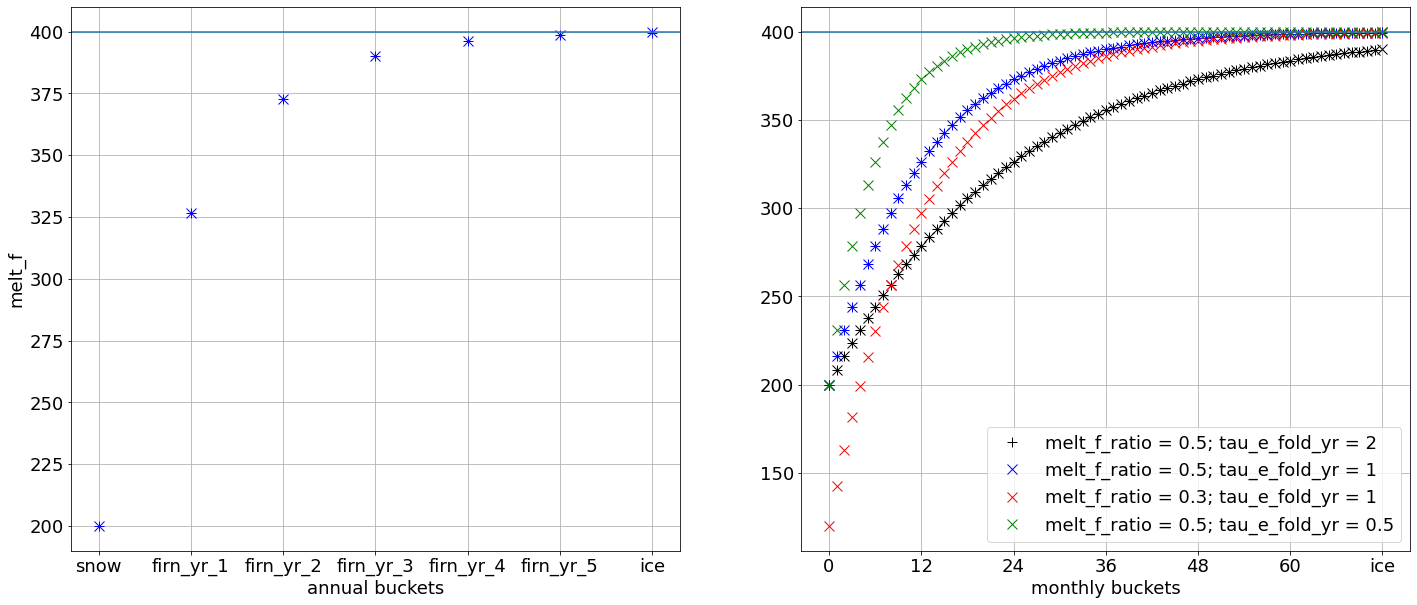

In [107]:
# with normal spinup for 6 years
melt_f_ice = 400
plt.figure(figsize=(24,10))
plt.subplot(121)
mb_mod_annual_0_5_a_neg_exp_tau_1yr = TIModel_Sfc_Type(gdir, melt_f_ice, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='annual',
                                          melt_f_change = 'neg_exp', 
                                          tau_e_fold_yr = 1, # default
                                          baseline_climate=baseline_climate)
plt.plot(mb_mod_annual_0_5_a_neg_exp_tau_1yr.buckets + ['ice'], 
         mb_mod_annual_0_5_a_neg_exp_tau_1yr.melt_f_buckets.values(), '+', markersize=10, color = 'blue')
meltis = np.fromiter(mb_mod_annual_0_5_a_neg_exp_tau_1yr.melt_f_buckets.values(), dtype=float)
meltis[-1] = melt_f_ice
plt.plot(mb_mod_annual_0_5_a_neg_exp_tau_1yr.buckets + ['ice'], meltis, 'x', markersize = 10, color = 'blue')
plt.xlabel('annual buckets')
plt.grid()
plt.ylabel('melt_f')
plt.axhline(400)

plt.subplot(122)

mb_mod_monthly_0_5_m_neg_exp_tau_2yr = TIModel_Sfc_Type(gdir, melt_f_ice, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='monthly',
                                          melt_f_change = 'neg_exp', 
                                          tau_e_fold_yr = 2, # default
                                          baseline_climate=baseline_climate)
plt.plot(mb_mod_monthly_0_5_m_neg_exp_tau_2yr.buckets + ['ice'], 
         mb_mod_monthly_0_5_m_neg_exp_tau_2yr.melt_f_buckets.values(), 'x', markersize=10, color = 'black')
meltis = np.fromiter(mb_mod_monthly_0_5_m_neg_exp_tau_2yr.melt_f_buckets.values(), dtype=float)
meltis[-1] = melt_f_ice
plt.plot(mb_mod_monthly_0_5_m_neg_exp_tau_2yr.buckets + ['ice'], meltis, '+', markersize = 10, color = 'black',
              label = 'melt_f_ratio = 0.5; tau_e_fold_yr = 2')


mb_mod_monthly_0_5_m_neg_exp_tau_1yr = TIModel_Sfc_Type(gdir, melt_f_ice, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='monthly',
                                          melt_f_change = 'neg_exp', 
                                          tau_e_fold_yr = 1, # default
                                          baseline_climate=baseline_climate)
plt.plot(mb_mod_monthly_0_5_m_neg_exp_tau_1yr.buckets + ['ice'], 
         mb_mod_monthly_0_5_m_neg_exp_tau_1yr.melt_f_buckets.values(), '+', markersize=10, color = 'blue')
meltis = np.fromiter(mb_mod_monthly_0_5_m_neg_exp_tau_1yr.melt_f_buckets.values(), dtype=float)
meltis[-1] = melt_f_ice
ax = plt.plot(mb_mod_monthly_0_5_m_neg_exp_tau_1yr.buckets + ['ice'], meltis, 'x', markersize = 10, color = 'blue',
              label = 'melt_f_ratio = 0.5; tau_e_fold_yr = 1')
#plt.xticks(np.linspace(0, 72)[::12])
           #, mb_mod_monthly_0_5_m_neg_exp_tau_1yr.buckets + ['ice'][::5])
plt.xticks(ticks=ax[-1].get_xdata()[::12])

mb_mod_monthly_0_5_m_neg_exp_tau_1yr = TIModel_Sfc_Type(gdir, melt_f_ice, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.3, prcp_fac=pf,
                                          melt_f_update='monthly',
                                          melt_f_change = 'neg_exp', 
                                          tau_e_fold_yr = 1, # default
                                          baseline_climate=baseline_climate)
meltis = np.fromiter(mb_mod_monthly_0_5_m_neg_exp_tau_1yr.melt_f_buckets.values(), dtype=float)

ax = plt.plot(mb_mod_monthly_0_5_m_neg_exp_tau_1yr.buckets + ['ice'], meltis, 'x', markersize = 10, color = 'red', label = 'melt_f_ratio = 0.3; tau_e_fold_yr = 1')

mb_mod_monthly_0_5_m_neg_exp_tau_1yr = TIModel_Sfc_Type(gdir, melt_f_ice, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='monthly',
                                          melt_f_change = 'neg_exp', 
                                          tau_e_fold_yr = 0.5, # default
                                          baseline_climate=baseline_climate)
meltis = np.fromiter(mb_mod_monthly_0_5_m_neg_exp_tau_1yr.melt_f_buckets.values(), dtype=float)

ax = plt.plot(mb_mod_monthly_0_5_m_neg_exp_tau_1yr.buckets + ['ice'], meltis, 'x', markersize = 10, color = 'green',
              label = 'melt_f_ratio = 0.5; tau_e_fold_yr = 0.5')

plt.xlabel('monthly buckets')
plt.legend()
plt.axhline(400)
plt.grid()


- it approximates the melt_f_ice but not reaches it exactly. especially if tau_e_fold_yr > 1 yr and melt_f_ratio>=0.5, should we tweak it to always match the ice melt_f for the ice bucket? 

#### cosipy approach
- I don't know if this makes sense, as I would need to know the depth (snow density) and also need to assume that melt_f depends inverse linearly to the albedo ... 

In [16]:
alpha_s = 0.9
alpha_f = 0.55
alpha_i = 0.3 
t_albedo = 22 # 22 days (albedo timescale)
d_star = 0.03 # cm ...  albedo depth scale
# I need d (thickness of the snowpack !!!)
density = 400 # kg/m3 mean of fresh snow and firn ... normally should be different for each bucket, and dependen on how much pressure was imposed to it ... so depending on height
# density = density_ice - (density_ice - density_snow)*exp(-C*z) # z snow depth, 
melt_f_ice = mb_mod_monthly_0_5_m.melt_f # this is of ice 


In [135]:
s = np.linspace(0, 6, len(mb_mod_annual_0_5_a.buckets + ['ice']))
s[-1] = 10 # to make sure that this represents really the ice section !!!

In [136]:
tau_e_fold_yr = 0.5 #t_albedo
melt_f_snow = melt_f_ice/2
p2 = melt_f_snow - melt_f_ice
#s = pd_bucket.columns # in months*365/12
melt_f = melt_f_ice + (melt_f_snow - melt_f_ice)* np.exp(-(s)/tau_e_fold_yr) # s: in months


In [115]:
melt_f_linear = melt_f_snow + s * (melt_f_ice-melt_f_snow)/(6*12)

Text(0.5, 0, 'monthly buckets')

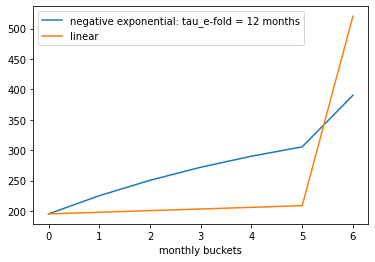

In [120]:
plt.plot(melt_f,label = 'negative exponential: tau_e-fold = 12 months')
plt.plot(melt_f_linear, label = 'linear')
plt.legend()
plt.xlabel('monthly buckets')

Text(0.5, 0, 'monthly buckets')

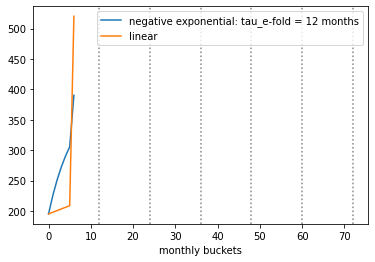

In [119]:
plt.plot(melt_f,label = 'negative exponential: tau_e-fold = 12 months')
plt.plot(melt_f_linear, label = 'linear')
plt.legend()
for y in np.arange(1,7,1):
    plt.axvline(12*y, color = 'grey', ls = ':', alpha = 0.6)
    plt.axvline(12*y, color = 'grey', ls = ':', alpha = 0.6)
plt.xlabel('monthly buckets')

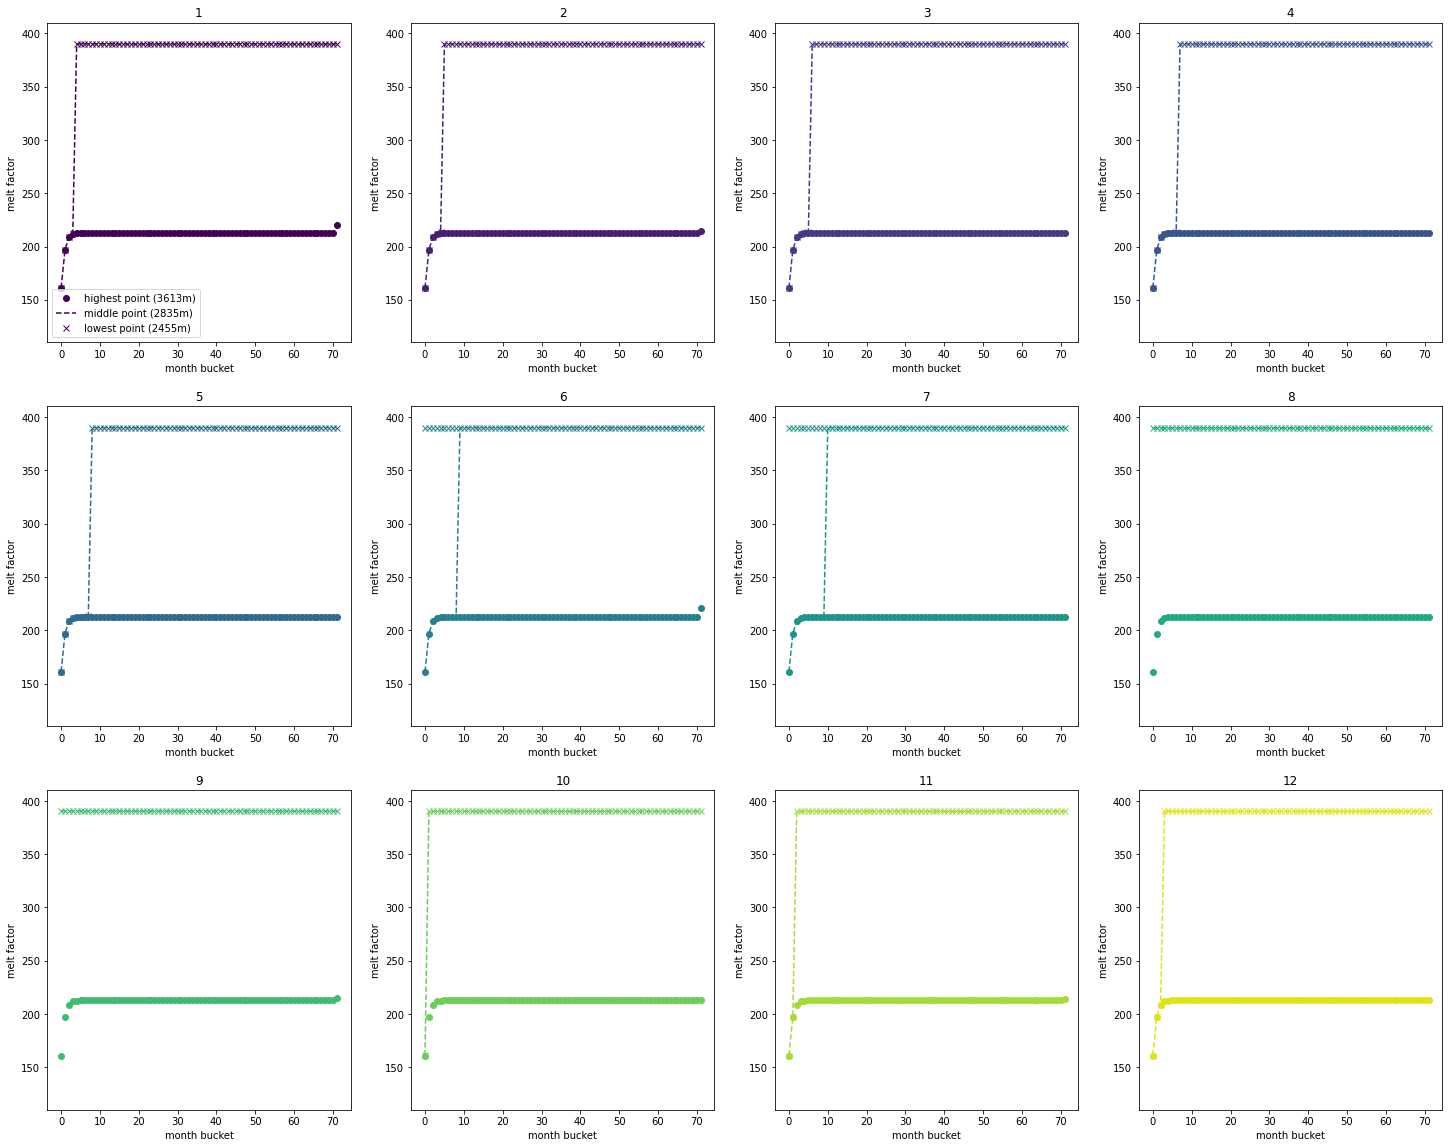

In [18]:

#(d,s, alpha)
plt.figure(figsize=(25,20))
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 0.95, 12)]

#colors = ['cyan', 'grey', 'green', 'orange', 'red', 'sierra', 'brown', 'blue']
mb_mod_monthly_0_5_m.reset_pd_mb_bucket()
alpha_pds = {}
melt_f_pds = {}
for j,m in enumerate(np.arange(1,13,1)):
    plt.subplot(3,4,j+1)
    plt.title(m)
    _, pd_bucket = mb_mod_monthly_0_5_m.get_monthly_mb(h, date_to_floatyear(2000, m=m), bucket_output=True)
    pd_bucket = pd_bucket[mb_mod_monthly_0_5_m.columns[:-1]].copy()
    # here I only want to have the amount of snow beneath that bucket!!! 
    #(because I want to have the theoretical melt factor if there would be no snow in the upper buckets!!!)
    #bucket_kg_m2_total = pd_bucket.sum(axis=1).values
    pd_bucket_cumsum = pd_bucket[pd_bucket.columns[::-1]].cumsum(axis=1)
    pd_bucket_cumsum_kg_m2 = pd_bucket_cumsum[pd_bucket_cumsum.columns[::-1]]
    bucket_firn_snow_h = pd_bucket_cumsum_kg_m2 / density # kg/m2 / kg/m3
    
    # we don't have the snow depth, we could only add up all snow and firn buckets 
    #bucket_firn_snow_h = np.atleast_2d(bucket_kg_m2_total / density).T  # kg/m2 / kg/m3
    #bucket_firn_snow_h = 0.1 # corresponds to overall snowpack thickness, l
    # s = 30*m # number of days after last snowfall, let's say one month
    s = pd_bucket.columns*365/12 + 15 
    # s = np.linspace(0,5*365,5*365+1)
    #alpha_snow = []
    #for ss in s:
    #    alpha_snowi = alpha_f + (alpha_s-alpha_f)* np.exp(-ss/t_albedo)
    #    alpha_snow.append(alpha_snowi)
    alpha_snow = alpha_f + (alpha_s-alpha_f)* np.exp(-s/t_albedo)

    alpha_snow = np.atleast_2d(np.array(alpha_snow))
    alpha = alpha_snow + (alpha_i-alpha_snow)*np.exp(-bucket_firn_snow_h/d_star)
    alpha_pd = pd.DataFrame(alpha.values,
                            index=h.round(1),
                            columns=pd_bucket.columns)
    alpha_pds[m] = alpha_pd
    melt_f_pd = melt_f_ice / (alpha_pd/alpha_i)
    melt_f_pds[m] = melt_f_pd
    c = colors[j]
    plt.plot(pd_bucket.columns, melt_f_pd.iloc[0], 'o', label = 'highest point ({:0.0f}m)'.format(melt_f_pd.index[0], m), color = c)
    plt.plot(pd_bucket.columns, melt_f_pd.iloc[round(len(melt_f_pd.index)/2)],
             '--',  label = 'middle point ({:0.0f}m)'.format(melt_f_pd.index[round(len(melt_f_pd.index)/2)], m),
             color = c)
    plt.plot(pd_bucket.columns, melt_f_pd.iloc[-1], 'x', label='lowest point ({:0.0f}m)'.format(melt_f_pd.index[-1], m),
            color = c)
    if m == 1:
        plt.legend()
    plt.ylim([melt_f_ice /3-20, melt_f_ice+20 ])
    plt.ylabel('melt factor')

    plt.xlabel('month bucket')

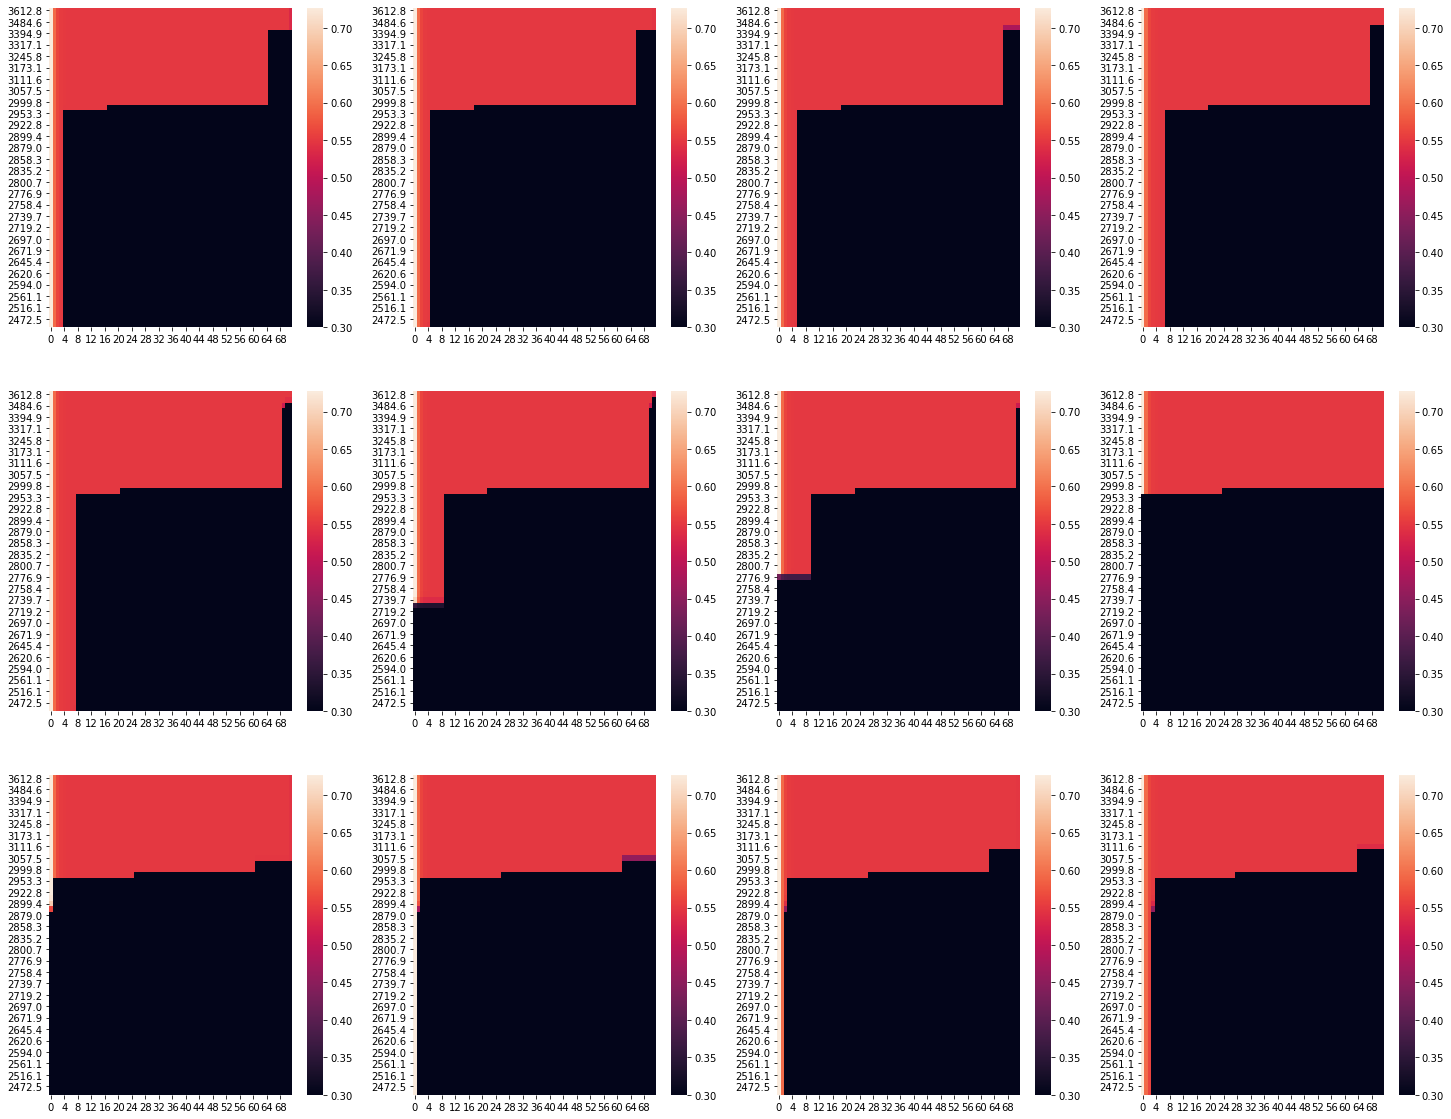

In [20]:
import seaborn as sns
plt.figure(figsize=(25,20))
for j,m in enumerate(np.arange(1,13,1)):
    plt.subplot(3,4,j+1)
    sns.heatmap(alpha_pds[m])
#(d,s, alpha)

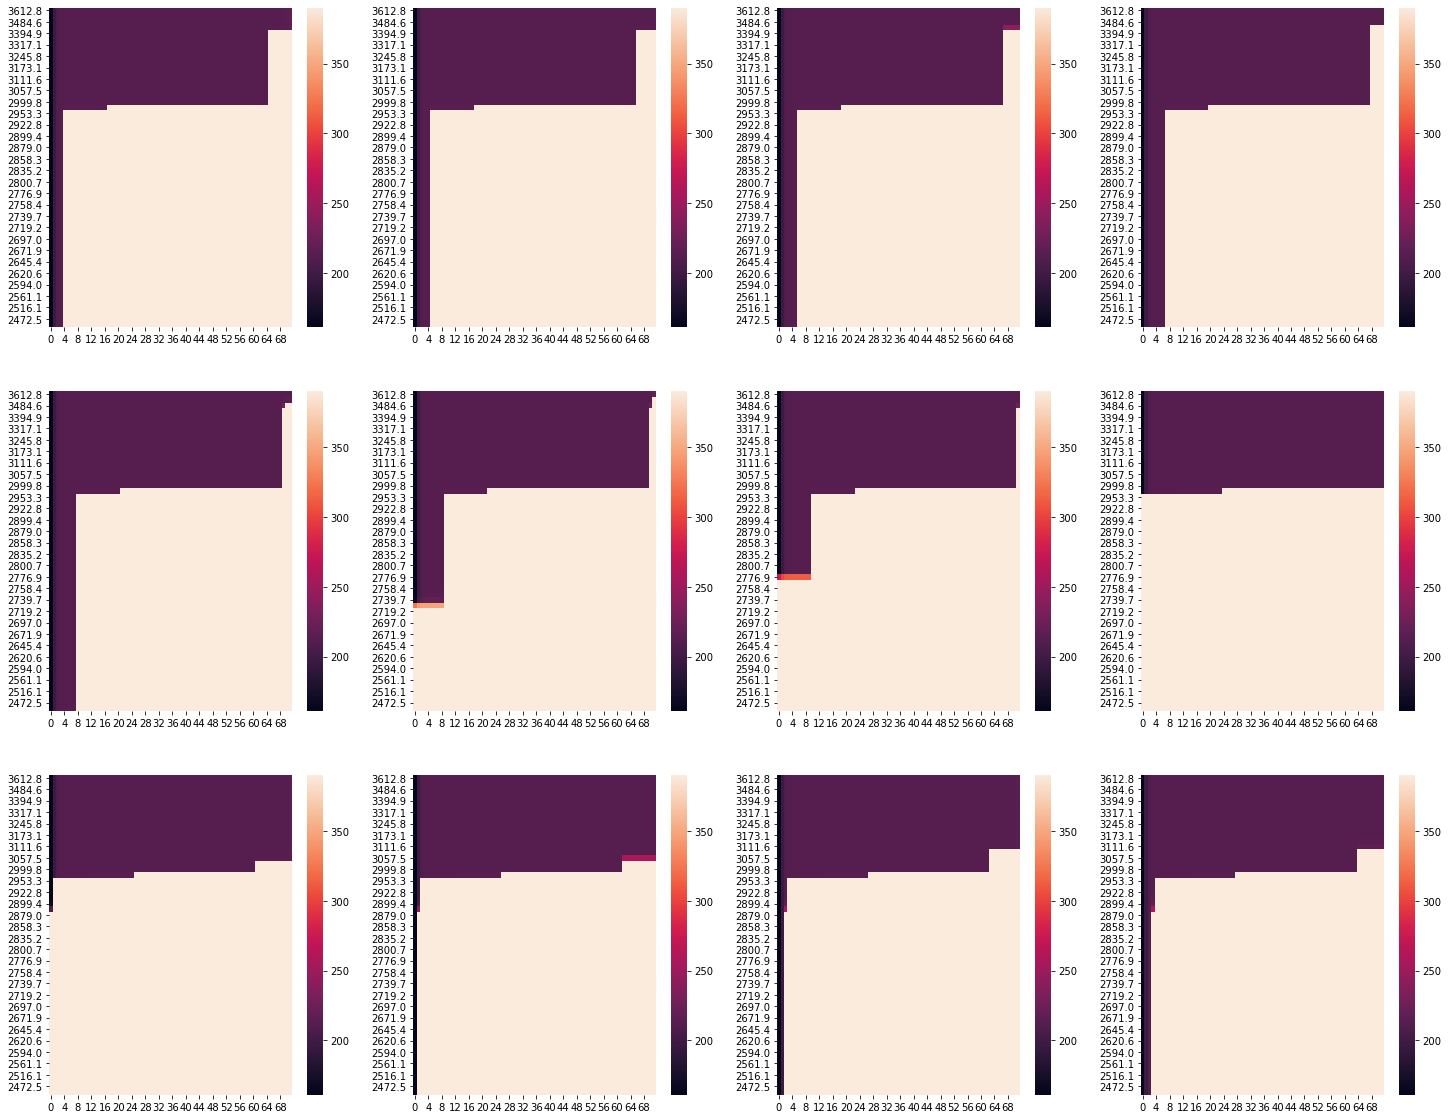

In [21]:
import seaborn as sns
plt.figure(figsize=(25,20))
for j,m in enumerate(np.arange(1,13,1)):
    plt.subplot(3,4,j+1)
    sns.heatmap(melt_f_pds[m])
#(d,s, alpha)

# Other plots (not so important right now)

In [18]:
# test as done in test_mb_modules_oneflowline.py
cfg.PARAMS['hydro_month_nh'] = 1
# just choose any random melt_f
melt_f = 200
pf = 2.5  # precipitation factor
df = ['RGI60-11.00897']


cfg.PARAMS['baseline_climate'] = 'ERA5dr'
oggm.shop.ecmwf.process_ecmwf_data(gdir, dataset='ERA5dr',
                                   output_filesuffix='_monthly_ERA5dr',
                                   )
#
mb_mod_1 = TIModel_Sfc_Type(gdir, melt_f, mb_type='mb_monthly',
                          melt_f_ratio_snow_to_ice=1, prcp_fac=pf)

mb_mod_no_sfc_type = TIModel(gdir, melt_f, mb_type='mb_monthly',
                             prcp_fac=pf)

h, w = gdir.get_inversion_flowline_hw()
year = 2000
_, temp2dformelt_1, _, prcpsol_1 = mb_mod_1._get_2d_annual_climate(h, year)
_, temp2dformelt_no_sfc_type, _, prcpsol_no_sfc_type = mb_mod_no_sfc_type._get_2d_annual_climate(h, year)

assert_allclose(temp2dformelt_1, temp2dformelt_no_sfc_type)
assert_allclose(prcpsol_1, prcpsol_no_sfc_type)

mb_annual_1 = mb_mod_1.get_annual_mb(h, year=2000)
mb_annual_no_sfc_type = mb_mod_no_sfc_type.get_annual_mb(h, year=2000)

assert_allclose(mb_annual_1, mb_annual_no_sfc_type)

# check if specific mass balance equal?
# use the years from geodetic data
# TODO: change this to 2020 when available
years = np.arange(2000, 2019)
fls = gdir.read_pickle('inversion_flowlines')
spec_1 = mb_mod_1.get_specific_mb(year=years, fls=fls)
spec_no_sfc_type = mb_mod_no_sfc_type.get_specific_mb(year=years, fls=fls)

assert_allclose(spec_1, spec_no_sfc_type)

# next: check if optimizer works for both !
# get
url = 'https://cluster.klima.uni-bremen.de/~oggm/geodetic_ref_mb/hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide.csv'
path = utils.file_downloader(url)
pd_geodetic = pd.read_csv(path, index_col='rgiid')
pd_geodetic = pd_geodetic.loc[pd_geodetic.period == '2000-01-01_2020-01-01']
mb_geodetic = pd_geodetic.loc[df].dmdtda.values * 1000

melt_f_opt_1 = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_1, mb_geodetic,
                                                       h, w, pf), disp=True)
mb_mod_1.melt_f = melt_f_opt_1

melt_f_opt_no_sfc_type = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                      xtol=0.01, args=(mb_mod_no_sfc_type,
                                                       mb_geodetic,
                                                       h, w, pf), disp=True)
mb_mod_no_sfc_type.melt_f = melt_f_opt_no_sfc_type
# they should optimize to the same melt_f
assert_allclose(melt_f_opt_1, melt_f_opt_no_sfc_type)

# check reproducibility
assert_allclose(melt_f_opt_1, 190.5106406914272)

spec_1 = mb_mod_1.get_specific_mb(year=years, fls=fls)
spec_no_sfc_type = mb_mod_no_sfc_type.get_specific_mb(year=years, fls=fls)

assert_allclose(spec_1, spec_no_sfc_type)

# now include the surface type distinction and choose the
# melt factor of snow to be 0.5* smaller than the melt factor of ice
mb_mod_0_5 = TIModel_Sfc_Type(gdir, melt_f, mb_type='mb_monthly',
                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf)
melt_f_opt_0_5 = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                      xtol=0.01, args=(mb_mod_0_5,
                                                       mb_geodetic,
                                                       h, w, pf),
                                      disp=True)
# check reproducibility

# the melt factor of only ice with surface type distinction should be
# higher than the "mixed" melt factor of ice (with snow) (as the snow melt factor
# is lower than the ice melt factor, as defined)
assert melt_f_opt_0_5 > melt_f_opt_1

mb_mod_0_5.melt_f = melt_f_opt_0_5
spec_0_5 = mb_mod_0_5.get_specific_mb(year=years, fls=fls)

# check if the optimised specific mass balance using a ratio of 0.5 is similar as
# the optimised spec. mb of no_sfc_type (i.e, ratio of 1)
# did the optimisation work?
assert_allclose(spec_0_5.mean(), mb_geodetic, rtol=1e-3)
assert_allclose(spec_0_5.mean(), spec_1.mean(), rtol=1e-3)
# the standard deviation can be quite different,
assert_allclose(spec_0_5.std(), spec_1.std(), rtol=0.3)


2021-07-09 16:12:44: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data_monthly_ERA5dr


In [19]:
mb_mod_0_75 = TIModel_Sfc_Type(gdir, melt_f, mb_type='mb_monthly',
                          melt_f_ratio_snow_to_ice=0.75, prcp_fac=pf)
melt_f_opt_0_75 = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                      xtol=0.01, args=(mb_mod_0_75,
                                                       mb_geodetic,
                                                       h, w, pf),
                                      disp=True)

mb_mod_0_75.melt_f = melt_f_opt_0_75
spec_0_75 = mb_mod_0_75.get_specific_mb(year=years, fls=fls)


In [21]:
# reinstanciate (otherwise we use the pd_bucket from the last year ...)
mb_mod_0_5.reset_pd_mb_bucket()
melt_f_opt_0_5_w_spinup = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                      xtol=0.01, args=(mb_mod_0_5,
                                                       mb_geodetic,
                                                       h, w, pf, False, np.arange(2000, 2019, 1),False, True # spinup!!!
                                                      ),
                                      disp=True)
mb_mod_0_5.melt_f = melt_f_opt_0_5_w_spinup


In [24]:
annual_mbs_0_5 = {}
annual_mbs_0_75 = {}
annual_mbs_1 = {}
annual_mbs_0_5_spinup = {}

mb_gradients = {0.5:[], 0.75: [], 1.0: [], '0.5_spinup': []}

rho=900
mb_mod_0_5.reset_pd_mb_bucket
mb_mod_0_75.reset_pd_mb_bucket()
mb_mod_1.reset_pd_mb_bucket()

for yr in np.arange(2000, 2019):
    annual_mb_0_5 = mb_mod_0_5.get_annual_mb(h, year=yr)*rho*cfg.SEC_IN_YEAR
    annual_mbs_0_5[yr] = annual_mb_0_5
    mb_gradient,_,_,_,_ = scipy.stats.linregress(h[annual_mb_0_5<0],
                                                 y=annual_mb_0_5[annual_mb_0_5<0])        
    mb_gradients[0.5].append(mb_gradient)
    
    annual_mb_0_75 = mb_mod_0_75.get_annual_mb(h, year=yr)*rho*cfg.SEC_IN_YEAR
    annual_mbs_0_75[yr] = annual_mb_0_75
    mb_gradient,_,_,_,_ = scipy.stats.linregress(h[annual_mb_0_75<0],
                                                 y=annual_mb_0_75[annual_mb_0_75<0])        
    mb_gradients[0.75].append(mb_gradient)
    
    annual_mb_1 = mb_mod_1.get_annual_mb(h, year=yr)*rho*cfg.SEC_IN_YEAR
    annual_mbs_1[yr] = annual_mb_1
    mb_gradient,_,_,_,_ = scipy.stats.linregress(h[annual_mb_1<0],
                                                 y=annual_mb_1[annual_mb_1<0])        
    mb_gradients[1.0].append(mb_gradient)

    
mb_mod_0_5.reset_pd_mb_bucket()
for yr in np.arange(2000, 2019):
    annual_mb_0_5_spinup = mb_mod_0_5.get_annual_mb(h, year=yr, spinup=True)*rho*cfg.SEC_IN_YEAR
    annual_mbs_0_5_spinup[yr] = annual_mb_0_5_spinup
    mb_gradient,_,_,_,_ = scipy.stats.linregress(h[annual_mb_0_5_spinup<0],
                                                 y=annual_mb_0_5_spinup[annual_mb_0_5_spinup<0])        
    mb_gradients['0.5_spinup'].append(mb_gradient)

In [25]:
mean_abl = pd.DataFrame(mb_gradients).mean()

Text(0, 0.5, 'specific mass balance (kg m$^{-2}$)')

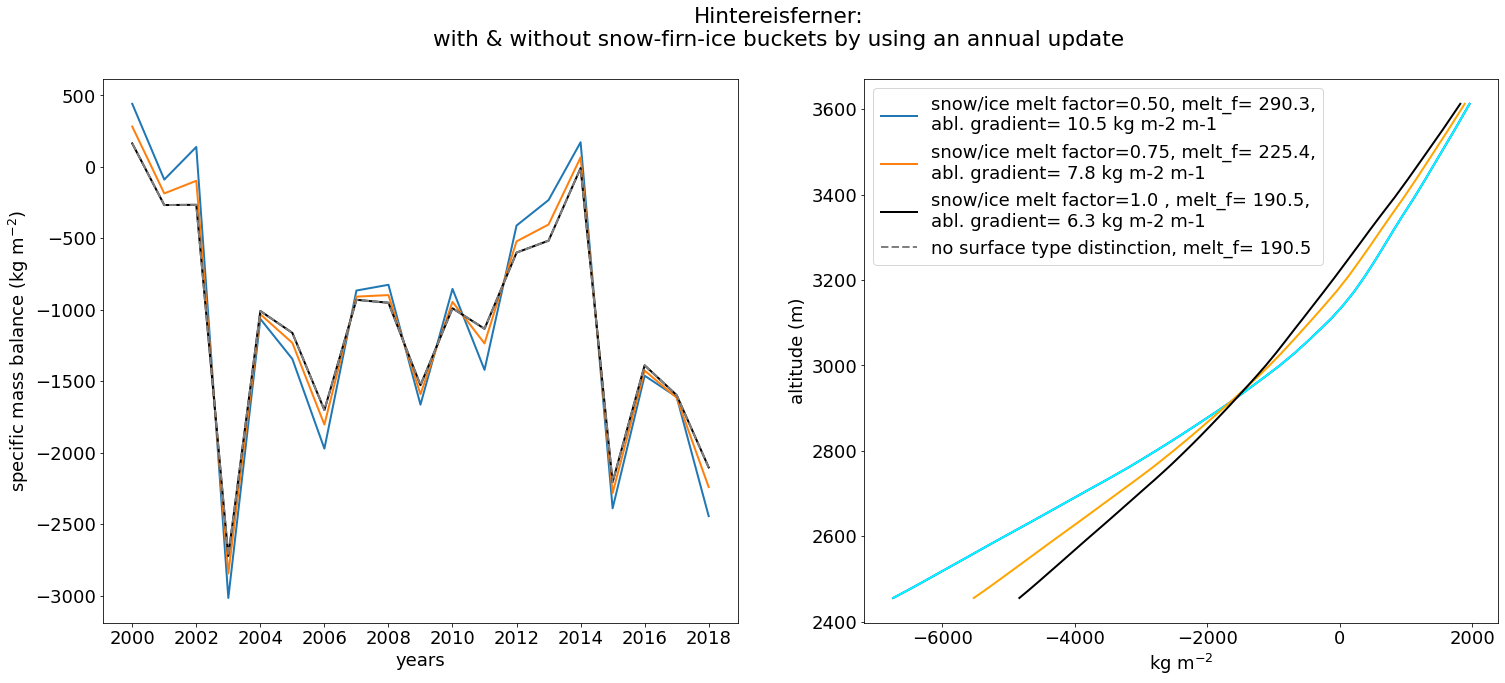

In [26]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(25, 10))
lw=2


plt.subplot(122)

plt.plot(pd.DataFrame(annual_mbs_0_5).mean(axis=1).values, h, label='ratio=0.5', color = 'blue', 
         lw=lw)
plt.plot(pd.DataFrame(annual_mbs_0_5).mean(axis=1).values, h, label='ratio=0.5 with spinup', color='cyan',
         lw=lw)
plt.plot(pd.DataFrame(annual_mbs_0_75).mean(axis=1).values, h, label='ratio=0.75',color='orange', 
         lw=lw)
plt.plot(pd.DataFrame(annual_mbs_1).mean(axis=1).values, h, label='ratio=1\n(no sfc type distinction)',
         color='black', lw=lw)
plt.xlabel('kg m$^{-2}$')
plt.ylabel('altitude (m)')
#plt.legend(title='mean annual mb:')
plt.suptitle('Hintereisferner:\nwith & without snow-firn-ice buckets by using an annual update')

plt.subplot(121)
plt.plot(years, spec_0_5, label='snow/ice melt factor=0.50, melt_f= {:0.1f},\nabl. gradient= {:0.1f} kg m-2 m-1'.format(melt_f_opt_0_5, mean_abl[0.5]),
         lw=lw)
plt.plot(years, spec_0_75, label='snow/ice melt factor=0.75, melt_f= {:0.1f},\nabl. gradient= {:0.1f} kg m-2 m-1'.format(melt_f_opt_0_75, mean_abl[0.75]),
         lw=lw)
plt.plot(years, spec_1, label='snow/ice melt factor=1.0 , melt_f= {:0.1f},\nabl. gradient= {:0.1f} kg m-2 m-1'.format(melt_f_opt_1, mean_abl[1.0]),
         color='black', lw=lw)
plt.plot(years, spec_no_sfc_type, '--', label='no surface type distinction, melt_f= {:0.1f}'.format(melt_f_opt_no_sfc_type),
         color='grey', lw=lw)

plt.xticks(np.arange(2000, 2020,2))

plt.legend(bbox_to_anchor=(1.2,1))
plt.xlabel('years')
plt.ylabel('specific mass balance (kg m$^{-2}$)')

- higher specific mass balance standard deviation, is this expected? 
- mass balance gradient is higher -> does this imply that the response time is shorter when including sfc type distinction ??? 
- the mb profiles with sfc type distinction look more reasonable, but is 0.5 the right value or should it rather be 0.75? 
    - we might at least try it out with 0.75 instead to see the differences ... 
    - at least for HEF: with that prcp-fac, with sfc type distinction is much more reasonable, as in the ablation zone mass balance is much more negative 
    - see Christoph Klug: Geodetic reanalysis of annual glaciological mass balance (for Hintereisferner), Fig. 4
    

## Old stuff that does ont run anymore, but could be adapted to work again

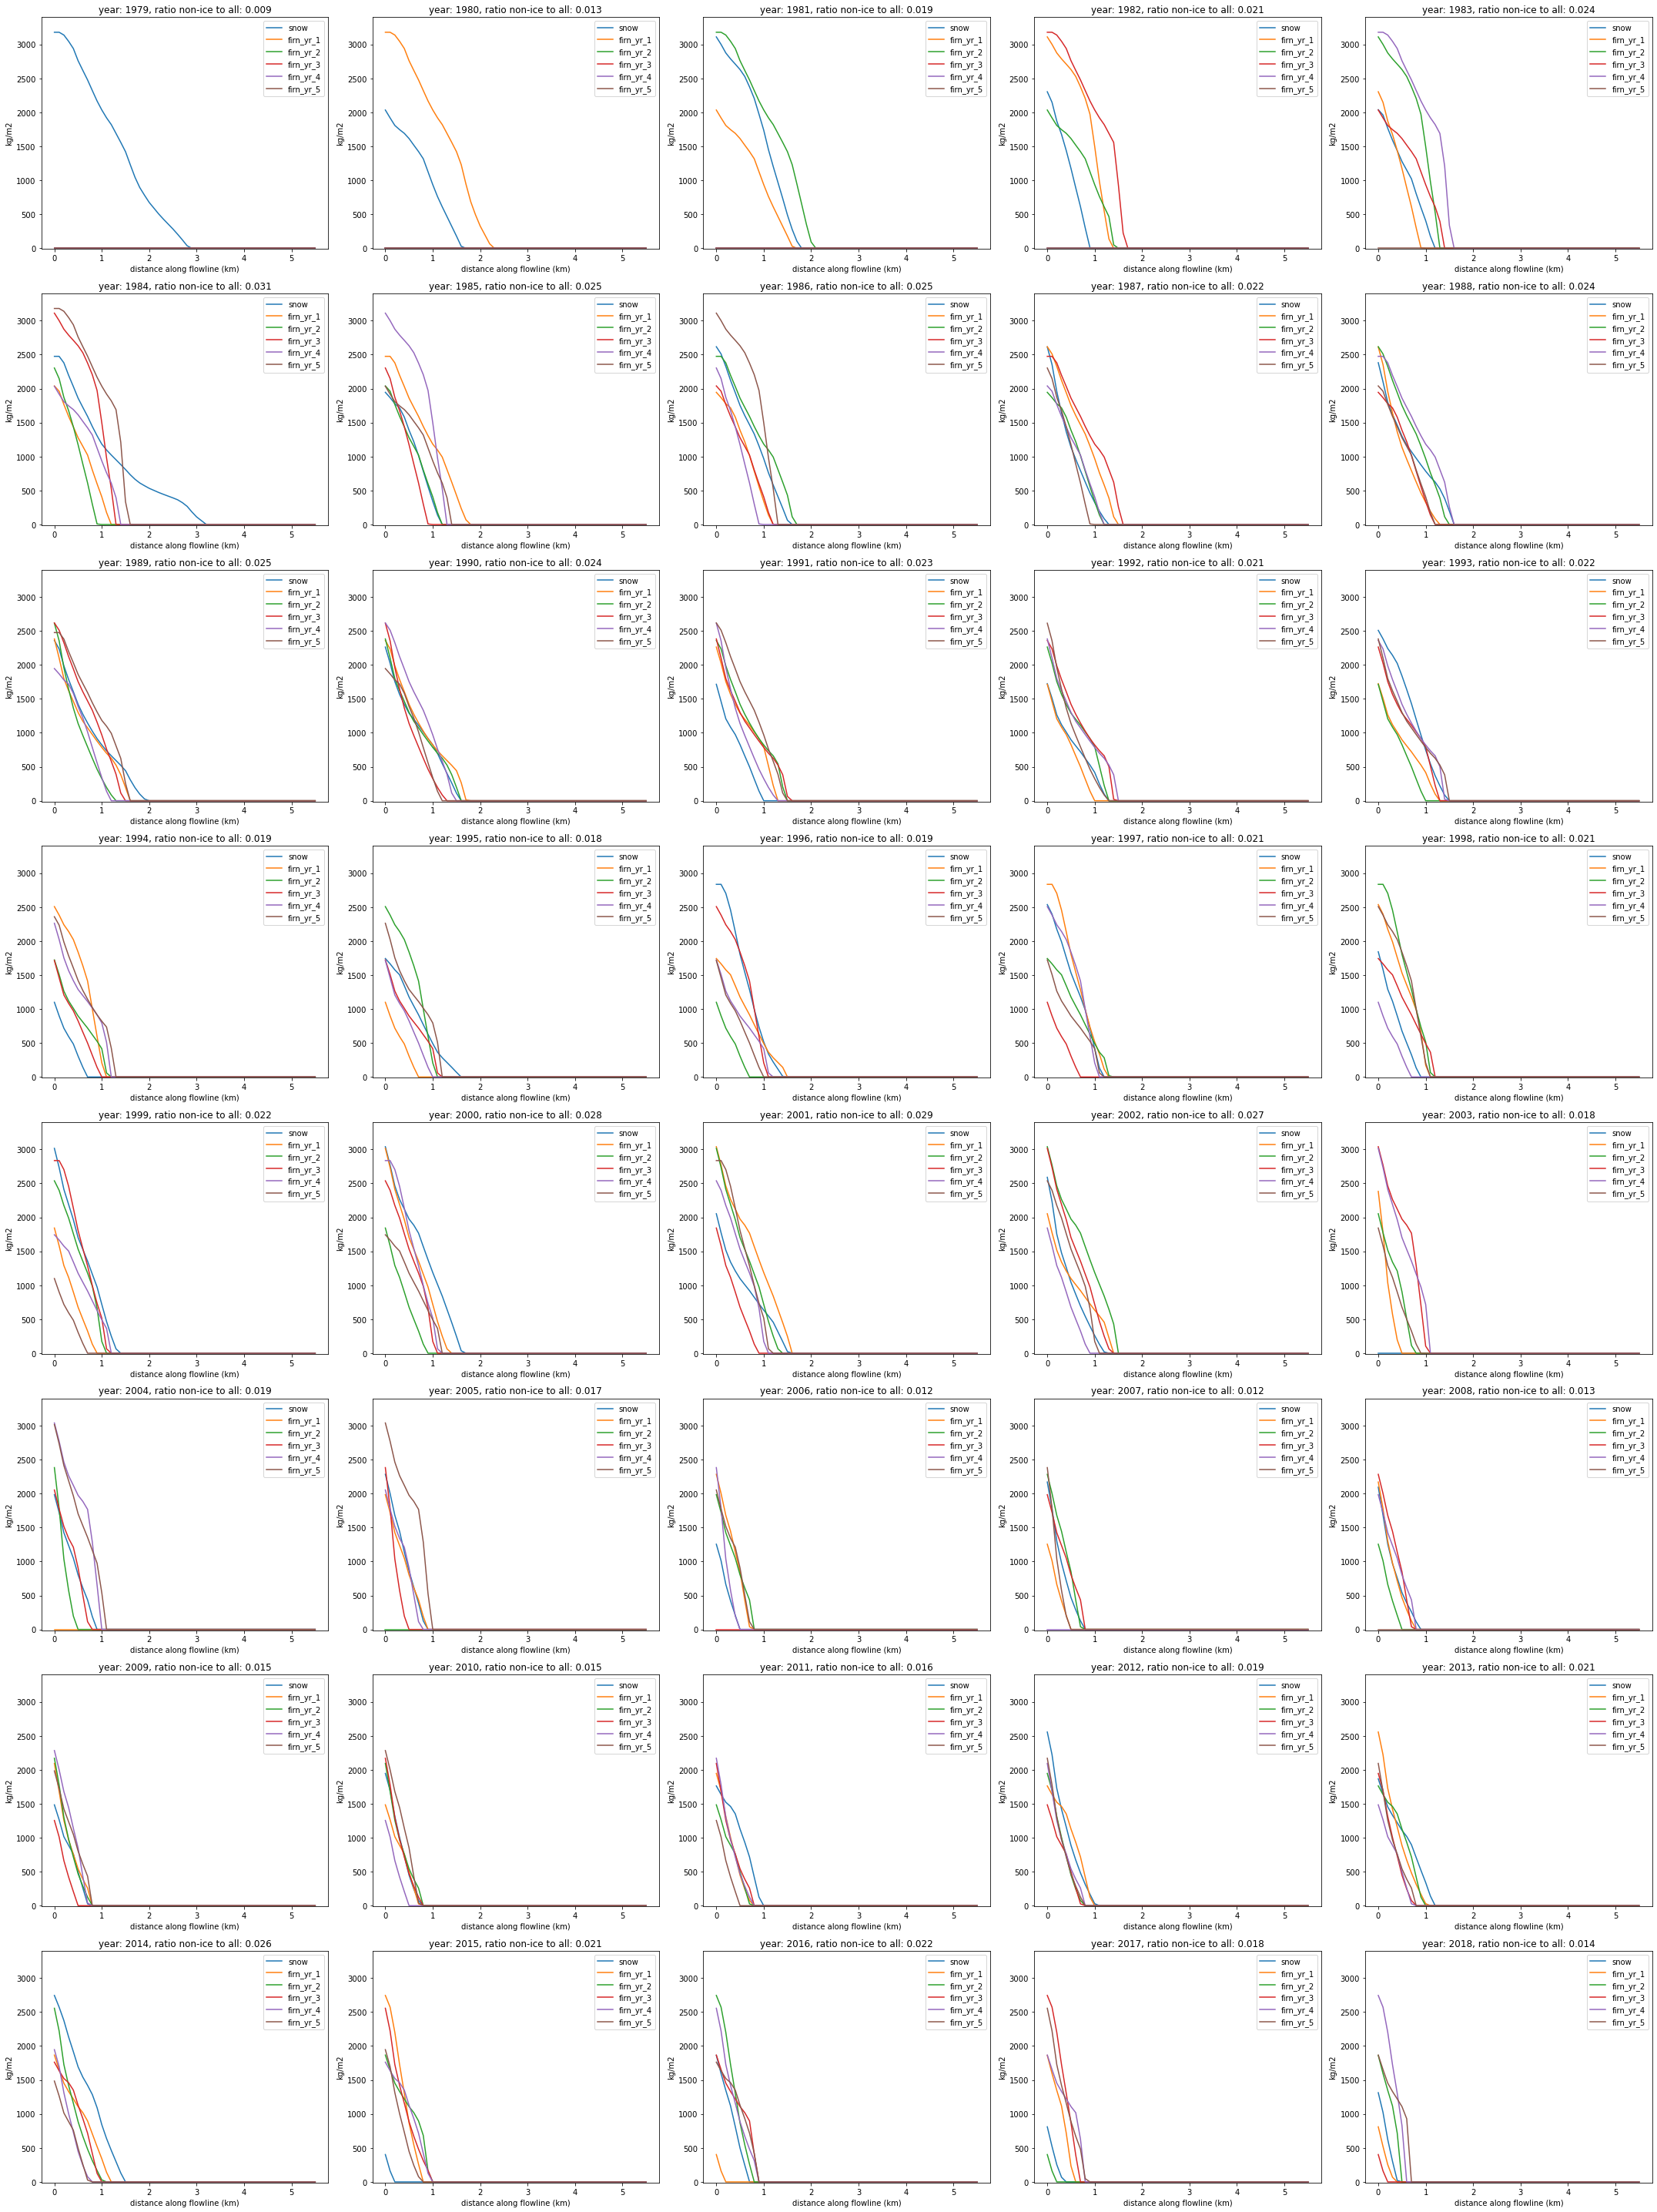

In [441]:
bucket_instance = SnowIceBuckets(mb_mod)
# when instanciated, everything is assumed to be ice in this simple setting, so after one year 
# still everything is ice -> there should be no changes 
# todo: instead instantiate with a reasonable amount of snow/firn/... over ELA 
# could use measurements e.g. from Hintereisferner (snow stake msm ) to do that but maybe too complicated
# and it does not matter ... 
np.testing.assert_allclose(bucket_instance.pd_bucket, bucket_instance.update() )

buckets = bucket_instance.buckets
# just to checkt if it worked right
previous_pd_bucket = bucket_instance.pd_bucket_init
ratios = []
elas = []
snow_ratios = []
plt.figure(figsize=(30,40))
for j, yr in enumerate(np.arange(1979, 2019)):
    if j>0:
        # update only after one year
        # snow -> firn , ...
        bucket_instance.update()
    
    
    pd_bucket = bucket_instance.add_delta_mb(yr)
    ###########
    # updated glacier extent(where total ice >0)
    glacier_extent = np.any(pd_bucket[buckets]>0, axis=1)
    if j==0:
        longest_glacier = glacier_extent
    # if first year is not year with longest glacier ... 
    if len(glacier_extent[glacier_extent]) > len(longest_glacier[longest_glacier]):
        longest_glacier = glacier_extent

    sum_diff = (pd_bucket[buckets]- previous_pd_bucket[buckets]).sum(axis=1)
    # the sum over all buckets differences over the glacier should be equal to delta_kg/m2 of each band
    np.testing.assert_allclose(sum_diff[glacier_extent],
                               pd_bucket['delta_kg/m2'][glacier_extent])
    # check if total ice mass has been updated the right way! 
    np.testing.assert_allclose(pd_bucket['total_kg/m2'][glacier_extent] - previous_pd_bucket['total_kg/m2'][glacier_extent],
                               pd_bucket['delta_kg/m2'][glacier_extent])
    #######
    
    
    previous_pd_bucket = bucket_instance.pd_bucket.copy()
    #print(yr)
    plt.subplot(8,5,j+1)
    ratio = bucket_instance.pd_bucket[buckets[:-1]].sum().sum()/bucket_instance.pd_bucket[buckets].sum().sum()
    for b in buckets[:-1]:
        plt.plot(bucket_instance.pd_bucket.loc[longest_glacier].index/1000,
                 bucket_instance.pd_bucket[b].loc[longest_glacier],
                 label = b)
    plt.legend()
    plt.title('year: {}, ratio non-ice to all: {}'.format(yr, np.round(ratio,3)))
    plt.ylabel('kg/m2')
    plt.xlabel('distance along flowline (km)')
    #print('ELA:')
    ela = bucket_instance.mb_mod.get_ela(yr)
    #print(ela.round(1))
    elas.append(ela)
    ratios.append(ratio)
    snow_ratio = pd_bucket['snow'].sum()/pd_bucket[buckets].sum().sum()
    snow_ratios.append(snow_ratio)
    plt.ylim([-10,3400])

plt.tight_layout()

- what was snow during 1979, is now firn_yr_1 in 1980, 
    - in uppest part: no melting occured in this year, 
    
- in 2003: 
    - model says that there is no snow, over the year that has stayed (ELA above highest point...), that means in the years afterwards, firn_yr_1 is 0, then firn_yr_2 is 0 and so on ... 

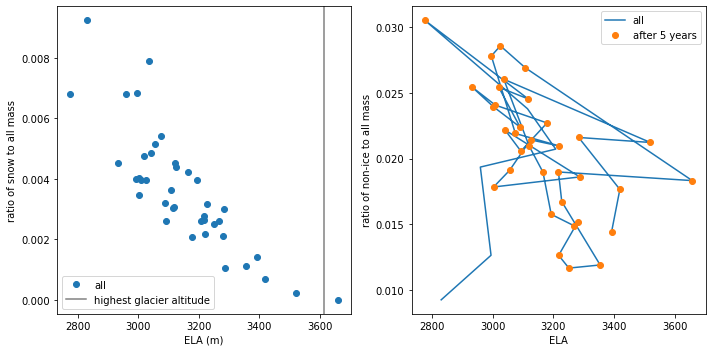

In [442]:
plt.figure(figsize=(10,5))
plt.subplot(122)
plt.plot(elas, ratios,'-', label='all')
plt.plot(elas[5:], ratios[5:],'o', label='after 5 years')
plt.ylabel('ratio of non-ice to all mass')
plt.xlabel('ELA')
plt.legend()
plt.subplot(121)
plt.plot(elas, snow_ratios, 'o', label='all')
plt.ylabel('ratio of snow to all mass')
plt.xlabel('ELA (m)')
plt.axvline(bucket_instance.mb_mod.fls[-1].surface_h[0], color='grey', label='highest glacier altitude')
plt.legend()
plt.tight_layout()

as expected (ok, here we just assume a HEF with a cte width as we sum all up):
- clear snow to mass ratio decrease with increasing ELA
    - if ELA above glacier, over the year no snow at all -> ratio = 0 
    
- ratio of non-ice to all mass is for HEF <= 0.03
    - can we say that in this case, density differences that result in different mass changes can be neglected? 
    
**but actually: we are more or only interested in the ratio of non-ice change to the total ice change from one year to the next???**
- specifically when we look at the aspect of using dhdt estimates and so on (because these are **changes** that are measured!!!

In [443]:
# example value
melt_f = 200

In [444]:
# chose linear increase but could also be an other relationshio
# -> do literture research on that
#melt_f_snow = melt_f / 2
melt_f_buckets = dict(zip(buckets, np.linspace(melt_f / 2, melt_f, 7)))
melt_f_buckets_ratio = dict(zip(buckets, np.linspace(melt_f / 2, melt_f, 7)/melt_f))

In [445]:
melt_f_buckets_ratio

{'snow': 0.5,
 'firn_yr_1': 0.5833333333333334,
 'firn_yr_2': 0.6666666666666667,
 'firn_yr_3': 0.75,
 'firn_yr_4': 0.8333333333333335,
 'firn_yr_5': 0.9166666666666667,
 'ice': 1.0}

In [458]:
utils.clip_min(-bucket_instance.pd_bucket[b].iloc[0]/melted,0)

0.43771455871468457

In [456]:
# let's say we have 
melted = 1000 # kg/m2 melted on first gridpoint 
# how would the mb_annual look like for that year?
# the problem is: we don't know how much kg/m2 is melted, we only now how much "temperature for melt" we have available
# need to do:
b = 'snow'
#melt_f_buckets[b] * utils.clip_min(-bucket_instance.pd_bucket[b].iloc[0]

In [461]:
# get_annual_mb_w_sfc_type()
# replicate get_annual_mb but with varying melt_f 
fact=1
_, temp2dformelt, _, prcpsol = bucket_instance.mb_mod.flowline_mb_models[-1]._get_2d_annual_climate(h, yr)

# this is a bit time consuming but maybe the only way ... 
# first assume there is enough snow there, so use 
mb_annual_snow = np.sum(prcpsol - melt_f_buckets['snow'] * temp2dformelt*fact,
                           axis=1)

# or I need to separate it from prcpsol somehow ...
#mb_annual = np.sum(prcpsol - melt_f_mean * temp2dformelt*fact,
#                           axis=1)
#return (mb_annual - self.residual) / self.SEC_IN_YEAR / self.rho

In [11]:
bucket_instance = SnowIceBuckets(mb_mod)
pd_bucket = bucket_instance.pd_bucket.copy()
#pd_bucket[longest_glacier]

In [576]:
bucket_instance = SnowIceBuckets(mb_mod)
pd_bucket = bucket_instance.pd_bucket.copy()
pd_bucket_old = pd_bucket.copy()
_, temp2dformelt, _, prcpsol = bucket_instance.mb_mod.flowline_mb_models[-1]._get_2d_annual_climate(h, yr)
# we treat here snow as the amount of solid prcp over the year 
# so we remove that 'temp for melt (tfm)' that equals to the amount of solid prcp when using the snow melt_f
# =: tfm to melt solid prcp
tfm_to_melt_solid_prcp = prcpsol.sum(axis=1)/ melt_f_buckets['snow']

 # remaining "temp for melt" that melts firn and ice layers ...
remaining_tfm = utils.clip_min(temp2dformelt.sum(axis=1) - tfm_to_melt_solid_prcp, 0)

# the new snow is added at the end ... 
# update the buckets by total added snow via taking the "negative" difference of tempfprmelt and tfm_to_melt_solid_prcp
added_snow = -utils.clip_max(temp2dformelt.sum(axis=1) - tfm_to_melt_solid_prcp, 0)*melt_f_buckets['snow']

index = pd_bucket.index[:len(remaining_tfm)]
# this will be updated by each bucket
pd_bucket.loc[index, 'delta_kg/m2'] = added_snow

pd_bucket.loc[index, 'snow'] = added_snow
for e,b in enumerate(buckets[1:]):
    index = pd_bucket.index[:len(remaining_tfm)]

    # for all buckets except snow
    # how much tempformelt would we need to remove all firn_yr_1
    tfm_to_melt_b = pd_bucket.loc[index, b].copy() / melt_f_buckets[b] # in K

    # that amount of firn_yr_1 is not melted -> reconvert it into kg/m2, and update the bucket accordingly
    # not do +=, because we just remove the calculation above as we assumed first that all would melt... 
    not_lost_bucket =  - utils.clip_max(remaining_tfm-tfm_to_melt_b, 0)*melt_f_buckets[b]
    
    # amount of kg/m2 lost in this bucket:
    # not yet updated total bucket - amoun of not lost mass of that bucket
    pd_bucket.loc[index, 'delta_kg/m2'] += not_lost_bucket - pd_bucket.loc[index, b].copy()

    
    pd_bucket.loc[index, b] = not_lost_bucket

    # remaining tfm to melt older firn layers -> for the next loop ... 
    if b != 'ice':
        remaining_tfm = utils.clip_min(remaining_tfm-tfm_to_melt_b, 0)
    # in case of ice, the remaining_tfm is just not used as there is no ice to be removed anymore ...

In [588]:
delta = pd_bucket.loc[index,'delta_kg/m2']
diff_new_old = (pd_bucket[buckets].sum(axis=1) - pd_bucket_old[buckets].sum(axis=1))[index]
np.testing.assert_allclose(delta, diff_new_old)

In [48]:
_, t2m,_ , prcpsol = bucket_instance_2._get_2d_annual_climate(h, 2000)

In [88]:
bucket_instance_1 = TIModel_Sfc_Type(gd, melt_f, mb_type='mb_monthly', melt_f_ratio_snow_to_ice=1)
bucket_instance_0_5 = TIModel_Sfc_Type(gd, melt_f, mb_type='mb_monthly', melt_f_ratio_snow_to_ice=2)


In [50]:
h, w = gd.get_inversion_flowline_hw()

In [62]:
#bucket_instance.get_annual_mb(h, year=2000)* cfg.SEC_IN_YEAR * 900

In [53]:
years = np.arange(1979, 2019)
mb_mod.melt_f = 200
print(mb_mod.melt_f)
spec_fixed_melt_f = mb_mod.get_specific_mb(fls=gd.read_pickle('inversion_flowlines'), # this is real fixed MB
                                           year = years )

NameError: name 'mb_mod' is not defined

Text(0.5, 0, 'year')

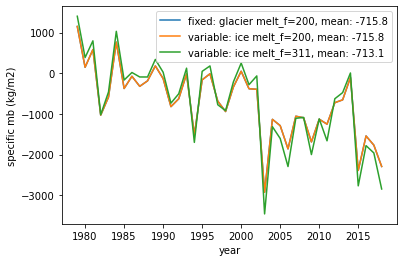

In [94]:
mb_mod = TIModel(gd, melt_f, mb_type='mb_monthly')

spec_fixed_melt_f = mb_mod.get_specific_mb(fls=gd.read_pickle('inversion_flowlines'), # this is real fixed MB
                                           year = years )

#print(bucket_instance.melt_f)
spec_var_melt_f = bucket_instance_1.get_specific_mb(year=years, fls=gd.read_pickle('inversion_flowlines') )

bucket_instance_0_5.melt_f = 311
spec_var_0_5_melt_f = bucket_instance_0_5.get_specific_mb(year=years, fls=gd.read_pickle('inversion_flowlines') )
plt.plot(years, spec_fixed_melt_f, label='fixed: glacier melt_f={}, mean: {}'.format(mb_mod.melt_f, np.round(spec_fixed_melt_f.mean(), 1)))
plt.plot(years, spec_var_melt_f, label='variable: ice melt_f={}, mean: {}'.format(bucket_instance_1.melt_f, np.round(spec_var_melt_f.mean(), 1)))
plt.plot(years, spec_var_0_5_melt_f, label='variable: ice melt_f={}, mean: {}'.format(bucket_instance_0_5.melt_f, np.round(spec_var_0_5_melt_f.mean(), 1)))

plt.legend()
plt.ylabel('specific mb (kg/m2)')
plt.xlabel('year')

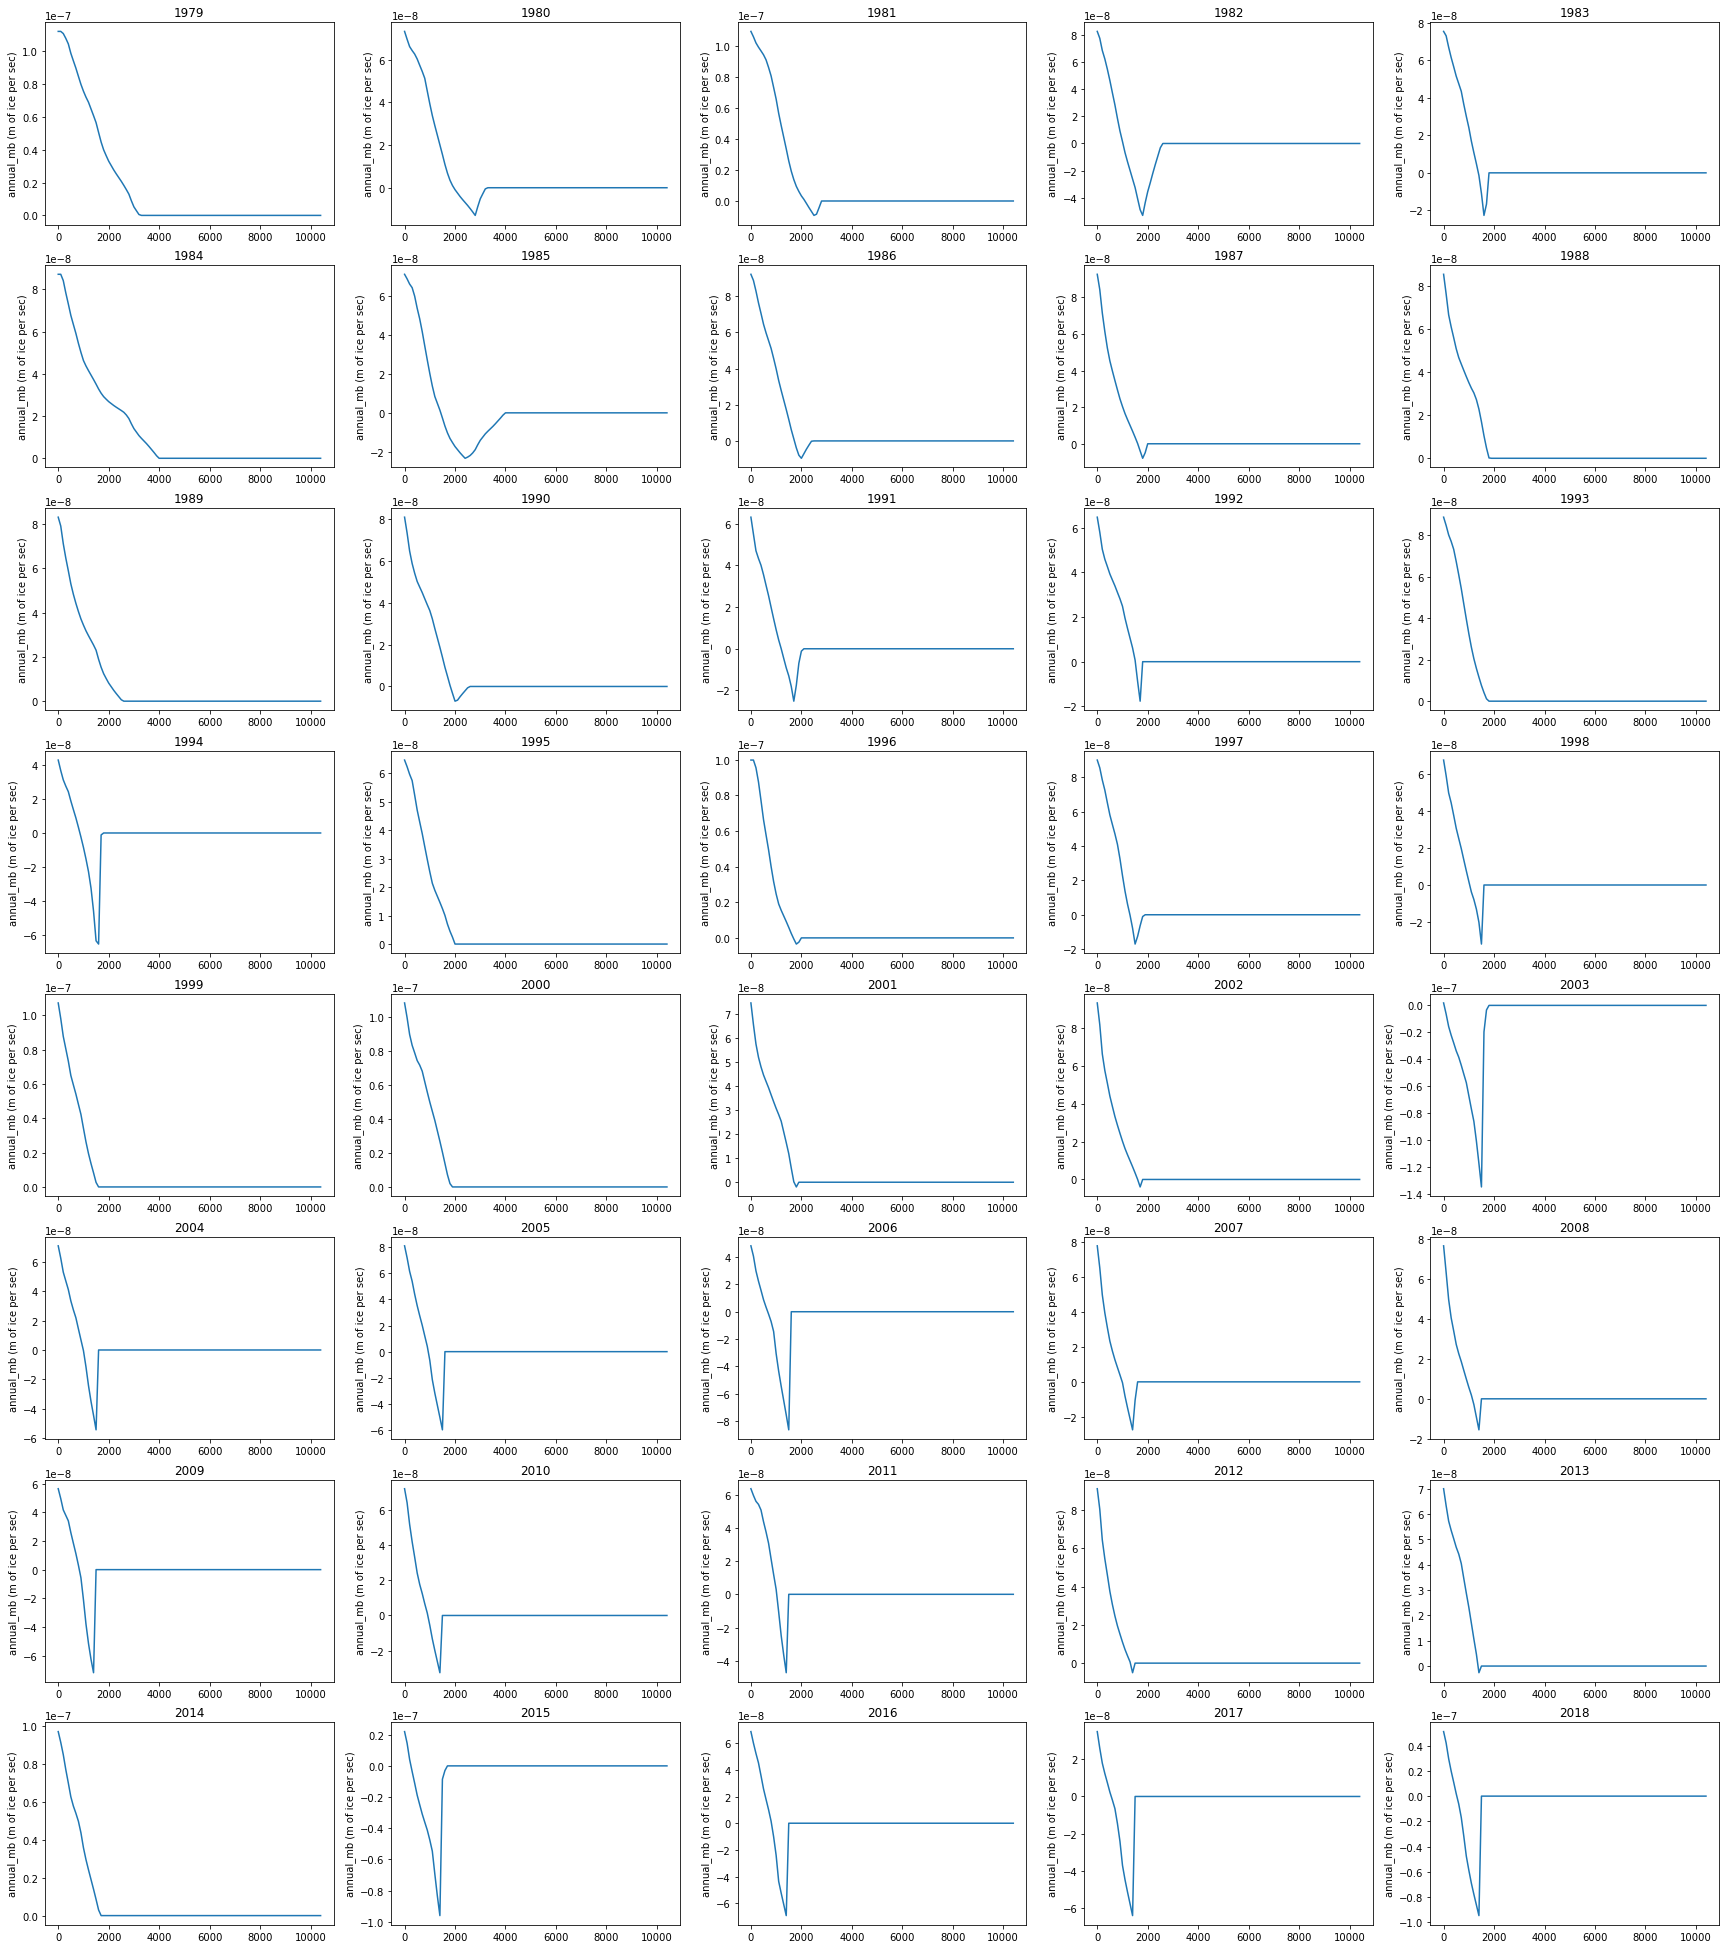

In [195]:
bucket_instance.melt_f = 340

plt.figure(figsize=(30, 35))
years = np.arange(1979, 2019)
for j, yr in enumerate(years):
    if j>0:
        # update only after one year
        # snow -> firn , ...
        bucket_instance.update()
    mb_annual = bucket_instance.get_annual_mb_w_vary_melt_f(bucket_instance.fl.surface_h, year=yr)
    plt.subplot(8,5,j+1)

    plt.plot(bucket_instance.pd_bucket.index, mb_annual)
    plt.title(yr)
    plt.ylabel('annual_mb (m of ice per sec)')

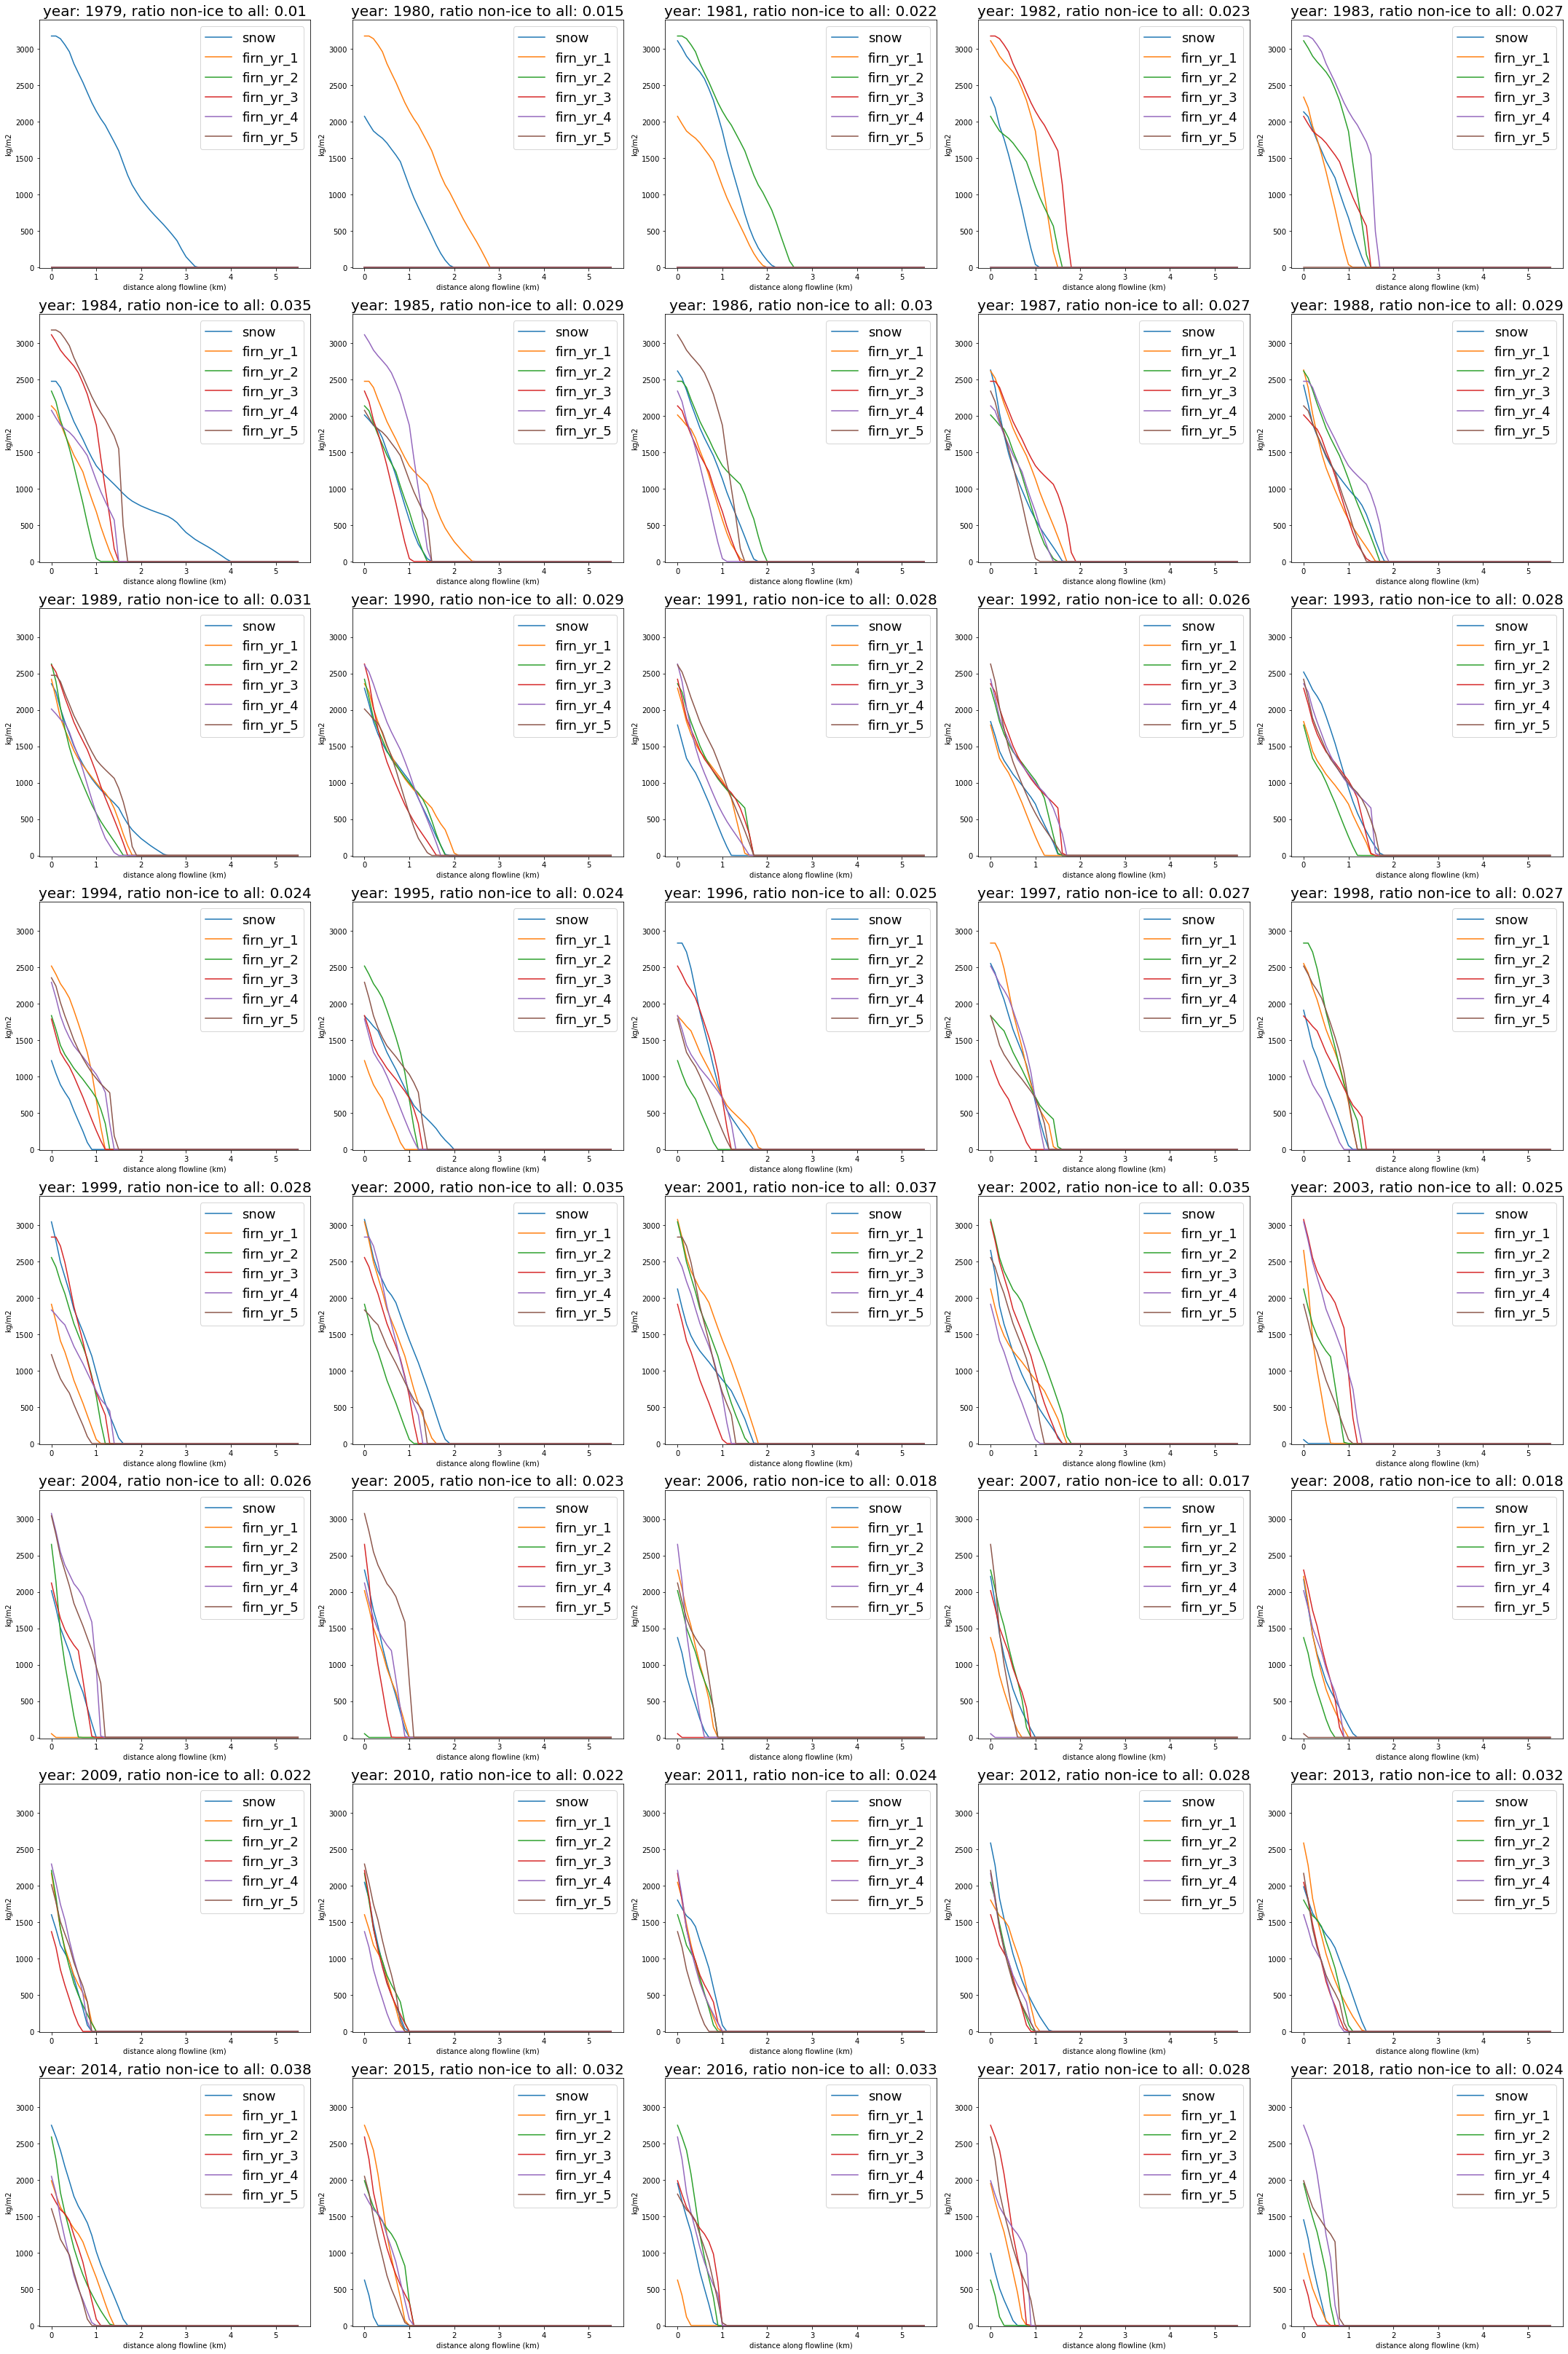

In [198]:
bucket_instance = SnowIceBuckets_melt_f(mb_mod)
bucket_instance.melt_f = 340

ratios = []
elas = []
snow_ratios = []
buckets = bucket_instance.buckets
plt.figure(figsize=(30, 45))
years = np.arange(1979, 2019)
for j, yr in enumerate(years):
    if j>0:
        # update only after one year
        # snow -> firn , ...
        previous_pd_bucket = pd_bucket.copy()
        bucket_instance.update()
    heights = bucket_instance.fl.surface_h
    # heights is always the same as it is NOT updated ...
    #print(heights)
    # problem: pd_bucket is not updated itself at the moment


    pd_bucket = bucket_instance.add_delta_mb_vary_melt_f(heights, year=yr)

    ratio = pd_bucket[buckets[:-1]].sum().sum()/pd_bucket[buckets].sum().sum()

    ela = bucket_instance.mb_mod.get_ela(yr)

    elas.append(ela)
    ratios.append(ratio)
    snow_ratio = pd_bucket['snow'].sum()/pd_bucket[buckets].sum().sum()
    snow_ratios.append(snow_ratio)
    
    
    glacier_extent = np.any(pd_bucket[buckets]>0, axis=1)
    if j==0:
        longest_glacier = glacier_extent
    # if first year is not year with longest glacier ... 
    if len(glacier_extent[glacier_extent]) > len(longest_glacier[longest_glacier]):
        longest_glacier = glacier_extent

    if j>0:
        sum_diff = (pd_bucket[buckets]- previous_pd_bucket[buckets]).sum(axis=1)
        # the sum over all buckets differences over the glacier should be equal to delta_kg/m2 of each band
        np.testing.assert_allclose(sum_diff[glacier_extent],
                               pd_bucket['delta_kg/m2'][glacier_extent])
    # check if total ice mass has been updated the right way! 
        np.testing.assert_allclose(pd_bucket['total_kg/m2'][glacier_extent] - previous_pd_bucket['total_kg/m2'][glacier_extent],
                               pd_bucket['delta_kg/m2'][glacier_extent])
    #######
    
    
    #print(yr)
    plt.subplot(8,5,j+1)
    for b in buckets[:-1]:
        plt.plot(pd_bucket.loc[longest_glacier].index/1000,
                 pd_bucket.loc[longest_glacier, b],
                 label = b)
    plt.legend(fontsize=18)
    plt.title('year: {}, ratio non-ice to all: {}'.format(yr, np.round(ratio,3)), fontsize=(20))
    plt.ylabel('kg/m2')
    plt.xlabel('distance along flowline (km)')
    plt.ylim([-10,3400])
plt.tight_layout()

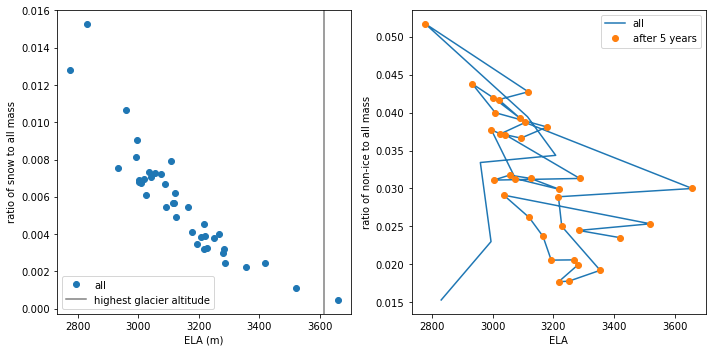

In [182]:
plt.figure(figsize=(10,5))
plt.subplot(122)
plt.plot(elas, ratios,'-', label='all')
plt.plot(elas[5:], ratios[5:],'o', label='after 5 years')
plt.ylabel('ratio of non-ice to all mass')
plt.xlabel('ELA')
plt.legend()
plt.subplot(121)
plt.plot(elas, snow_ratios, 'o', label='all')
plt.ylabel('ratio of snow to all mass')
plt.xlabel('ELA (m)')
plt.axvline(bucket_instance.mb_mod.fls[-1].surface_h[0], color='grey', label='highest glacier altitude')
plt.legend()
plt.tight_layout()

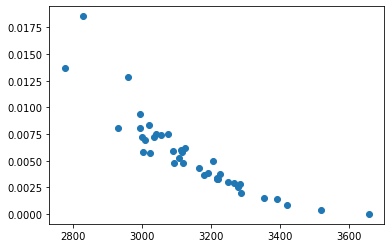

In [144]:
plt.plot(elas, snow_ratios, 'o')
# not exactly right because I assumed that glacier has cte width here

In [591]:
bucket_instance = SnowIceBuckets_melt_f(mb_mod)
# when instanciated, everything is assumed to be ice in this simple setting, so after one year 
# still everything is ice -> there should be no changes 
# todo: instead instantiate with a reasonable amount of snow/firn/... over ELA 
# could use measurements e.g. from Hintereisferner (snow stake msm ) to do that but maybe too complicated
# and it does not matter ... 
np.testing.assert_allclose(bucket_instance.pd_bucket, bucket_instance.update() )

buckets = bucket_instance.buckets
# just to checkt if it worked right
previous_pd_bucket = bucket_instance.pd_bucket_init
ratios = []
elas = []
snow_ratios = []
plt.figure(figsize=(30,40))
for j, yr in enumerate(np.arange(1979, 2019)):
    if j>0:
        # update only after one year
        # snow -> firn , ...
        bucket_instance.update()
    
    
    pd_bucket = bucket_instance.add_delta_mb(yr)
    ###########
    # updated glacier extent(where total ice >0)
    glacier_extent = np.any(pd_bucket[buckets]>0, axis=1)
    if j==0:
        longest_glacier = glacier_extent
    # if first year is not year with longest glacier ... 
    if len(glacier_extent[glacier_extent]) > len(longest_glacier[longest_glacier]):
        longest_glacier = glacier_extent

    sum_diff = (pd_bucket[buckets]- previous_pd_bucket[buckets]).sum(axis=1)
    # the sum over all buckets differences over the glacier should be equal to delta_kg/m2 of each band
    np.testing.assert_allclose(sum_diff[glacier_extent],
                               pd_bucket['delta_kg/m2'][glacier_extent])
    # check if total ice mass has been updated the right way! 
    np.testing.assert_allclose(pd_bucket['total_kg/m2'][glacier_extent] - previous_pd_bucket['total_kg/m2'][glacier_extent],
                               pd_bucket['delta_kg/m2'][glacier_extent])
    #######
    
    
    previous_pd_bucket = bucket_instance.pd_bucket.copy()
    #print(yr)
    plt.subplot(8,5,j+1)
    ratio = bucket_instance.pd_bucket[buckets[:-1]].sum().sum()/bucket_instance.pd_bucket[buckets].sum().sum()
    for b in buckets[:-1]:
        plt.plot(bucket_instance.pd_bucket.loc[longest_glacier].index/1000,
                 bucket_instance.pd_bucket[b].loc[longest_glacier],
                 label = b)
    plt.legend()
    plt.title('year: {}, ratio non-ice to all: {}'.format(yr, np.round(ratio,3)))
    plt.ylabel('kg/m2')
    plt.xlabel('distance along flowline (km)')
    #print('ELA:')
    ela = bucket_instance.mb_mod.get_ela(yr)
    #print(ela.round(1))
    elas.append(ela)
    ratios.append(ratio)
    snow_ratio = pd_bucket['snow'].sum()/pd_bucket[buckets].sum().sum()
    snow_ratios.append(snow_ratio)
    plt.ylim([-10,3400])

plt.tight_layout()

0

- at the moment, I still use the inversion to get estimates of the ice thickness, 
- instead do not use that, just consider delta_kg/m2:
    - the ice bucket is thought as an "infinite" bucket
    - at the first year everything is ice, and then it accumulates over the next years 
    - I guess best is to change it directly in the annual_mb:
        -  if apply sfc type distinction, want to "update" the buckets as one year passed and want to add the delta_mb to pd_buckets

    - e.g. when doing get_specific_mb for several years, need to save "sth" to give it to the next year ...
        - also important then when doing the minimizing approach ...
    - but still then need to check how this info is then saved and given to the next years, when run_for_climate is done ..
    